# Uncorrelated Inhibition

Here we set the figures for the cases with only excitation in spines.

In [1]:
import numpy as np
from numpy.random import exponential, randint
from numpy import *   #ones, cumsum, sum, isscalar
from matplotlib.pylab import * 
%matplotlib inline
plotose = True
import pickle

import PS_lib as lb
import PS_storage as st

## Setting up the model

### Topology of the neuron

We set first a simplistic neuron

In [2]:
# Parameter definitions
# Data is stored here      
data = st.dataStorage() # some default parameters defined.
data.dt = 0.05
data.NMDA = False

# Definition of the model.
lb.h.dt = data.dt
NMDA = data.NMDA
model = lb.loadNeuron("Basic2.hoc",axon=False)
# Adding piece of dendritic branch with spine
model.addDend(name="DendE",locus="dendA1",L=4.0,D=1.5,ilocus=1)
model.addSpne(locus="DendE",ilocus=0.5,L=1.0,D=1.0,Lneck=1.0,Dneck=0.15)
data.model = model.__dict__
# Temperature of the neuron
lb.h.celsius = model.temperature
print("Topology:")
print(lb.h.topology())

	0 
	1 
	1 
	1 
	1 
Topology:

|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


In [3]:
model.addDend(name="DendN",locus=3,L=240.0,D=0.5,ilocus=1)

print(lb.h.topology())


|-|       soma(0-1)
   `|       dendA1c(0-1)
     `|       dendA1(0-1)
       `|       DendE(0-1)
         `|       DendN(0-1)
        `|       NSpne000(0-1)
          `|       Spne000(0-1)
   `|       dendB1(0-1)

1.0


In [4]:
model.soma.L = 20
model.dend[-1].L = 200
model.dend[-1].diam = 10
model.soma.L,model.soma.diam,model.soma(0.5).area(),model.dend[-1](0.5).area()

(20.0, 29.78380012512207, 1871.3713533814052, 6283.185307179586)

### Recording places

We set recording vectors in all dendritic compartments, spine included

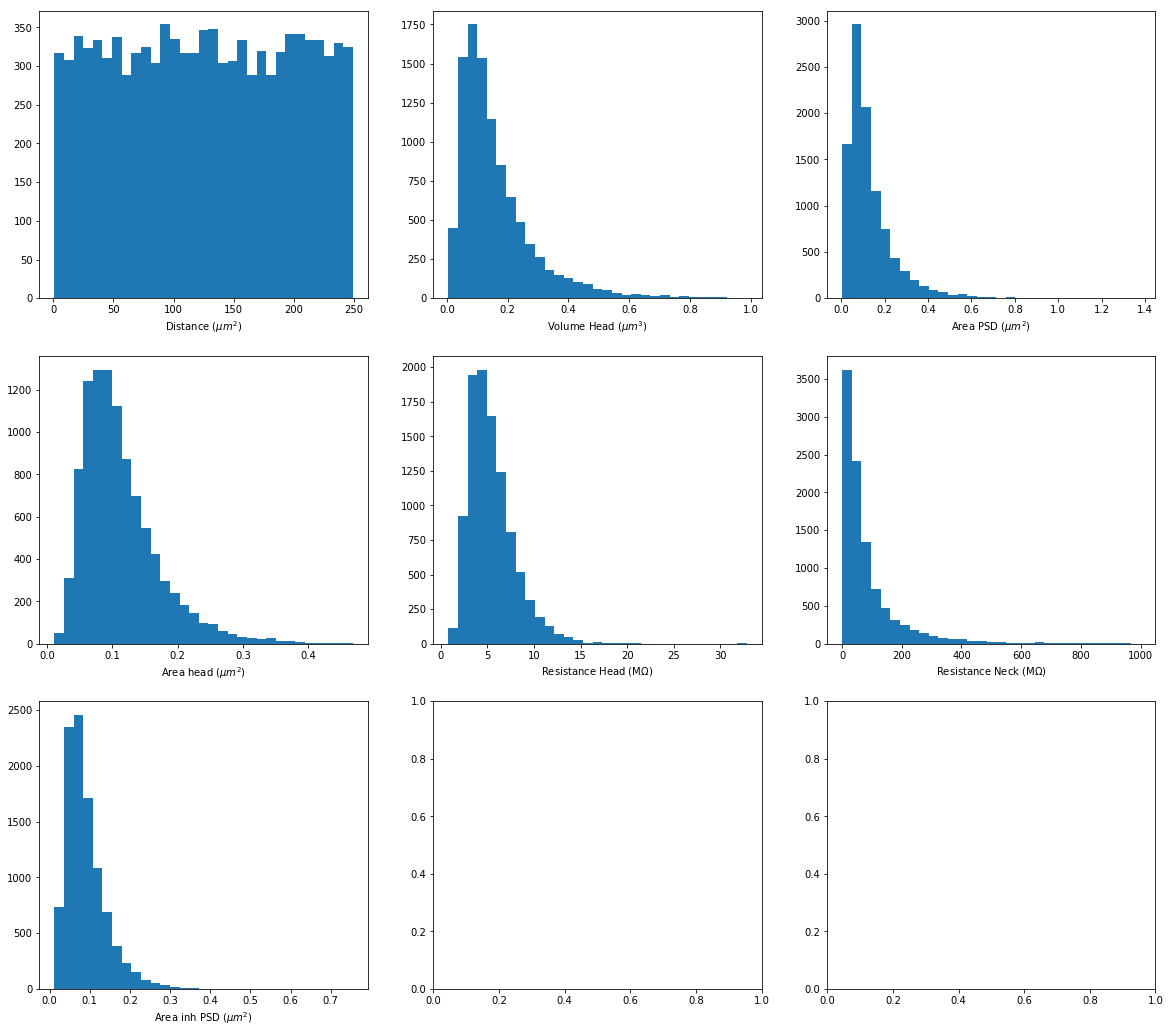

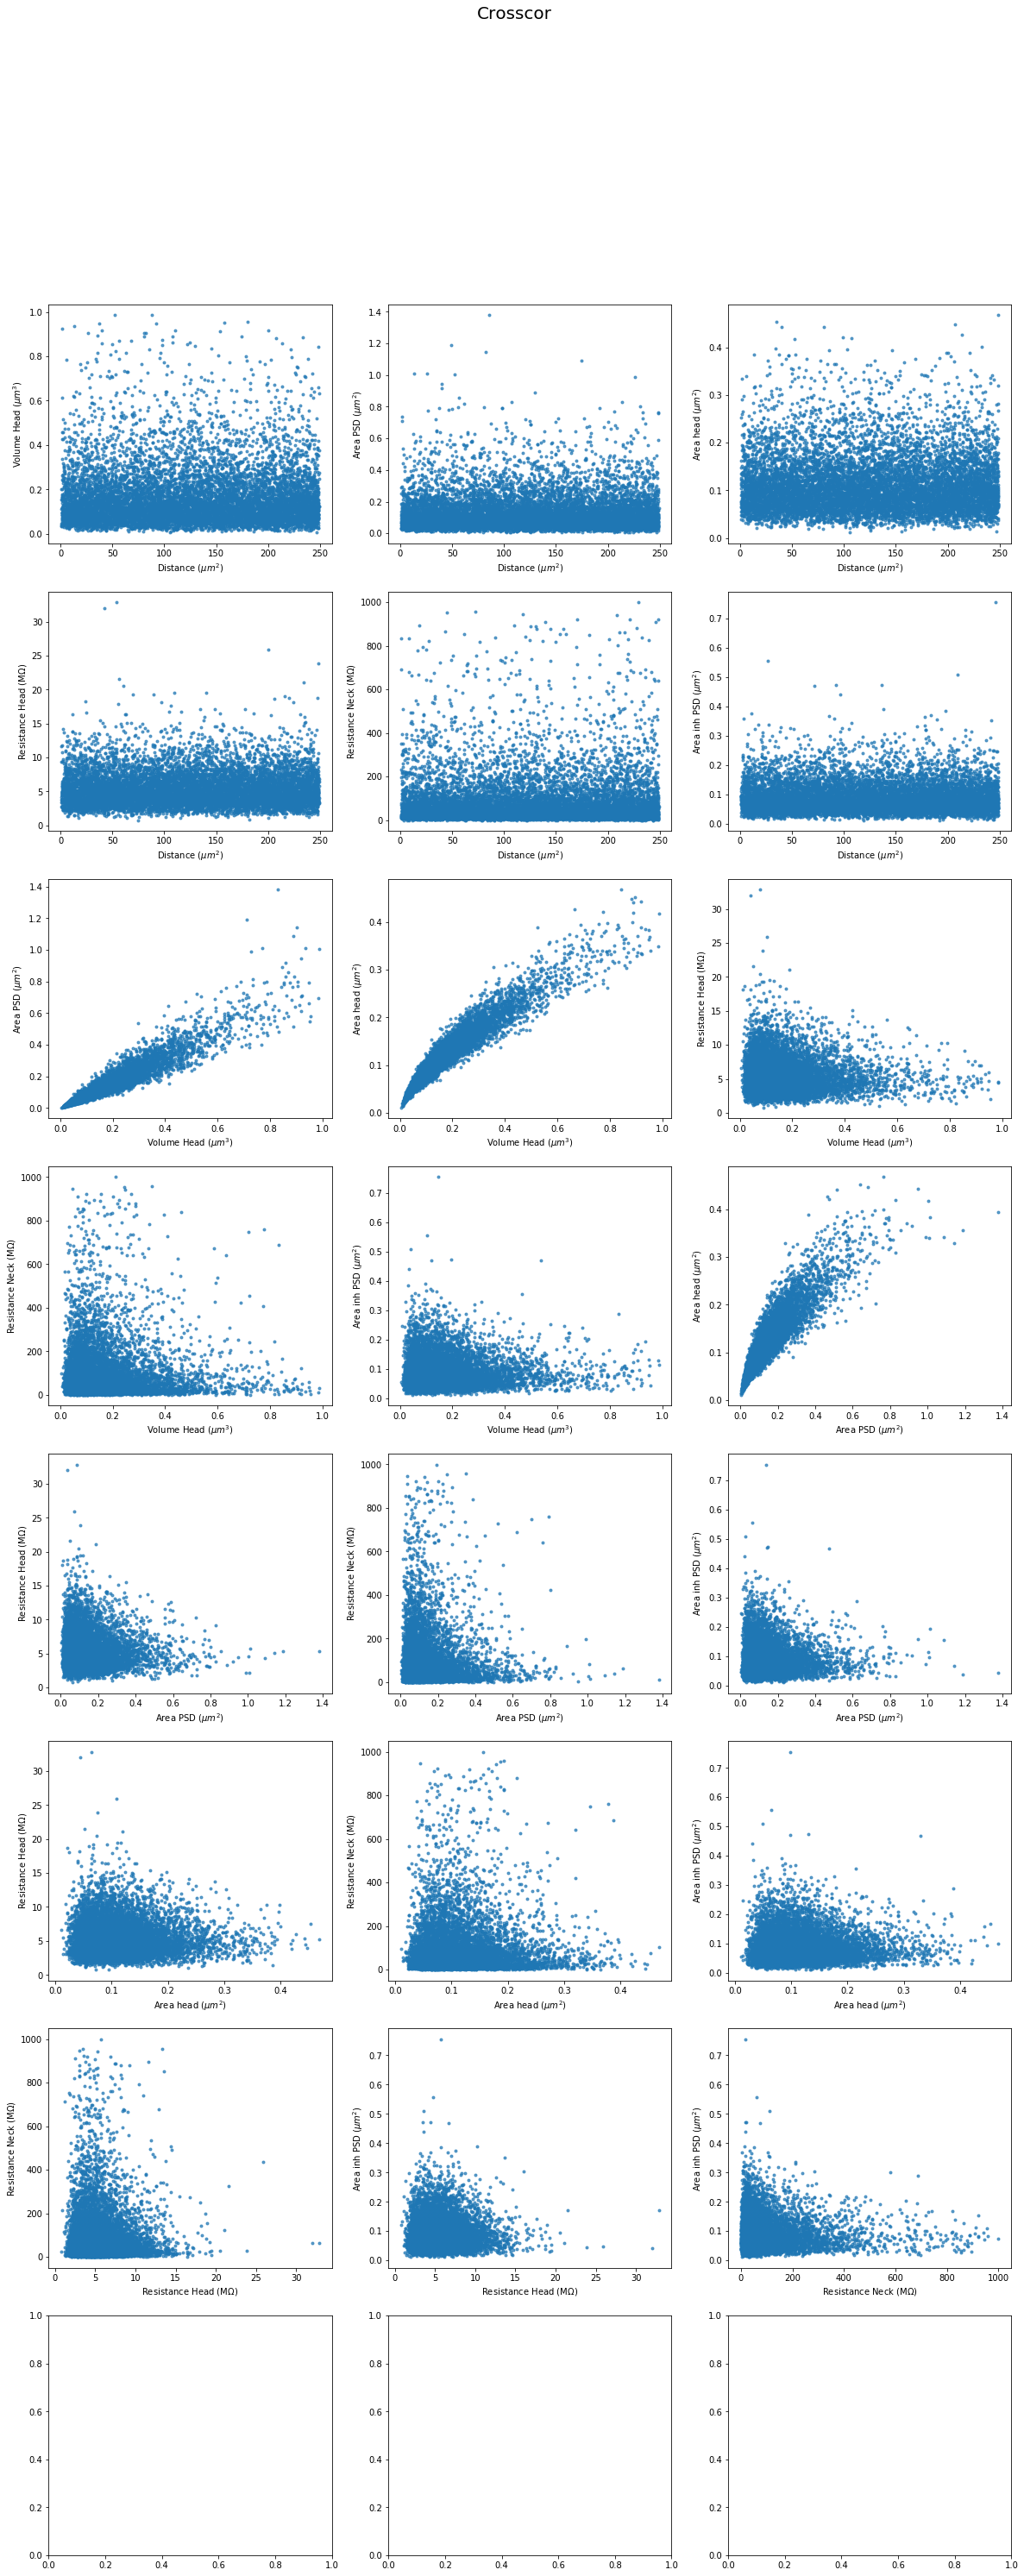

In [5]:
dendsizeL0 = 20
dendsizeL = 200

data = {
"inh shaft": (-2.01288, 0.606754),
"SiS": {
"Dss": (dendsizeL-2, 1.0),
"Vh": (-2.84134 , 0.943684),
"A1": (-0.2329858,0.41,1.0),
"Ah": (-0.9274113,1.32,0.66666666667),
"Rh":  (1.92772, 0.604723),
"Rn":(4.03436, 1.00208)
},
"DiS": {
"Dss": (dendsizeL-2.0, 1.0),
"Vh": (-2.0554,0.742202),
"A1": (-0.2329858,0.21,1.0),
"Ah": (-0.9274113,0.12,0.66666666667),
"Rh": (1.59667,0.436302),  
"Rn": (3.89941,1.13159),
"A2": ( -2.54262,0.531551)
},
}

labels = {
"Dss": "Distance ($\mu m^2$)",
"Vh": "Volume Head ($\mu m^3$)",
"A1": "Area PSD ($\mu m^2$)",
"A2": "Area inh PSD ($\mu m^2$)",
"Ah": "Area head ($\mu m^2$)",
"Rh": "Resistance Head (M$\Omega$)",  
"Rn": "Resistance Neck (M$\Omega$)"
}

    
dmethods = {
"Dss": ("uni",""),
"Vh": ("lgn",""),
"A1": ("cor","Vh"),
"Ah": ("cor","Vh"),
"Rh": ("lgn",""),  
"Rn": ("lgn",""),
"A2": ("lgn","")
}
dclip = {"Rn": (0,1e3),
        "Vh": (0,1)}

def generateSetSpines(nsp,dpar,labels,dmethods,dclip = None,plot = False,corplot = False, ptitle = ""):
    spines = {}
    nkeys = len(dpar.keys())
    if plot:
        nr = nkeys//3+1
        fig1, ax = subplots(nrows=nr,ncols=3,figsize=(20,6*nr))
        fig1.suptitle(ptitle,fontsize = 20)
    else:
        fig1 = ""
    for i,key in enumerate(dpar.keys()):
        #print(key)
        p = dpar[key]
        if dmethods[key][0] == "lgn":
            spines[key] = exp(randn(nsp)*p[1]+p[0])
        elif dmethods[key][0] == "uni":
            spines[key] = rand(nsp)*p[0]+p[1]
        elif dmethods[key][0] == "nor":
            spines[key] = randn(nsp)*p[1]+p[0]
            
    for i,key in enumerate(dpar.keys()):
        #print("Second",key)
        if dmethods[key][0] == "cor":
            key2 = dmethods[key][1]
            p = dpar[key]
            spines[key] = spines[key2]**p[2]*exp(randn(nsp)*p[1]+p[0])
        
        if dclip is not None:
            try:
                cl = dclip[key]
                
                sel0 = (spines[key]>cl[1])+(spines[key]<cl[0])
                lsel0 = sel0.sum()
                #print(lsel0,key)
                if lsel0>0:
                    temp = spines[key][sel0]
                    sel = (temp>cl[1])+(temp<cl[0])
                    lsel = sel.sum()
                    while lsel>0:
                        if dmethods[key][0] == "lgn":
                            temp = exp(randn(lsel)*p[1]+p[0])
                        elif dmethods[key][0] == "uni":
                            temp = rand(lsel)*p[0]+p[1]
                        elif dmethods[key][0] == "nor":
                            temp = randn(lsel)*p[1]+p[0]
                        elif dmethods[key][0] == "cor":
                            key2 = dmethods[key][1]
                            p = dpar[key]
                            temp = spines[key2][sel]**p[2]*exp(randn(lsel)*p[1]+p[0])
                        sel = (temp>cl[1])+(temp<cl[0])
                        lsel = sel.sum()
                        #print(lsel)

                    spines[key][sel0] = temp
                    
            except:
                pass
        if plot== True:
            ax[i//3,i%3].hist(spines[key],31)
            ax[i//3,i%3].set_xlabel(labels[key])
    
    if corplot == True:
        nt = sum(arange(nkeys))
        nr = nt//3+1
        fig2, ax = subplots(nrows=nr,ncols=3,figsize=(20,6*nr))
        fig2.suptitle("Crosscor",fontsize = 20)
        nkeys = len(dpar.keys())
        k = 0
        for i in range(nkeys):
            key = list(dpar.keys())[i]
            for j in range(i+1,nkeys):
                key2 = list(dpar.keys())[j]
                ax[k//3,k%3].plot(spines[key],spines[key2],'.',alpha=0.7)
                ax[k//3,k%3].set_xlabel(labels[key])
                ax[k//3,k%3].set_ylabel(labels[key2])
                k += 1
    else:
        fig2 = ""
    spines["nsp"] = nsp

    #if ~plot and ~corplot:
    #    return(spines)
    #else:
    
    figs = (fig1,fig2)
    return(spines,figs)

dis,figs = generateSetSpines(10000,data["DiS"],labels,dmethods,dclip,plot=True,corplot= True)
figs[0].savefig("Bootstrap_Dist.png")
figs[1].savefig("Bootstrap_Crsc.png")

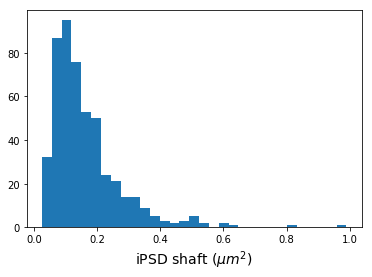

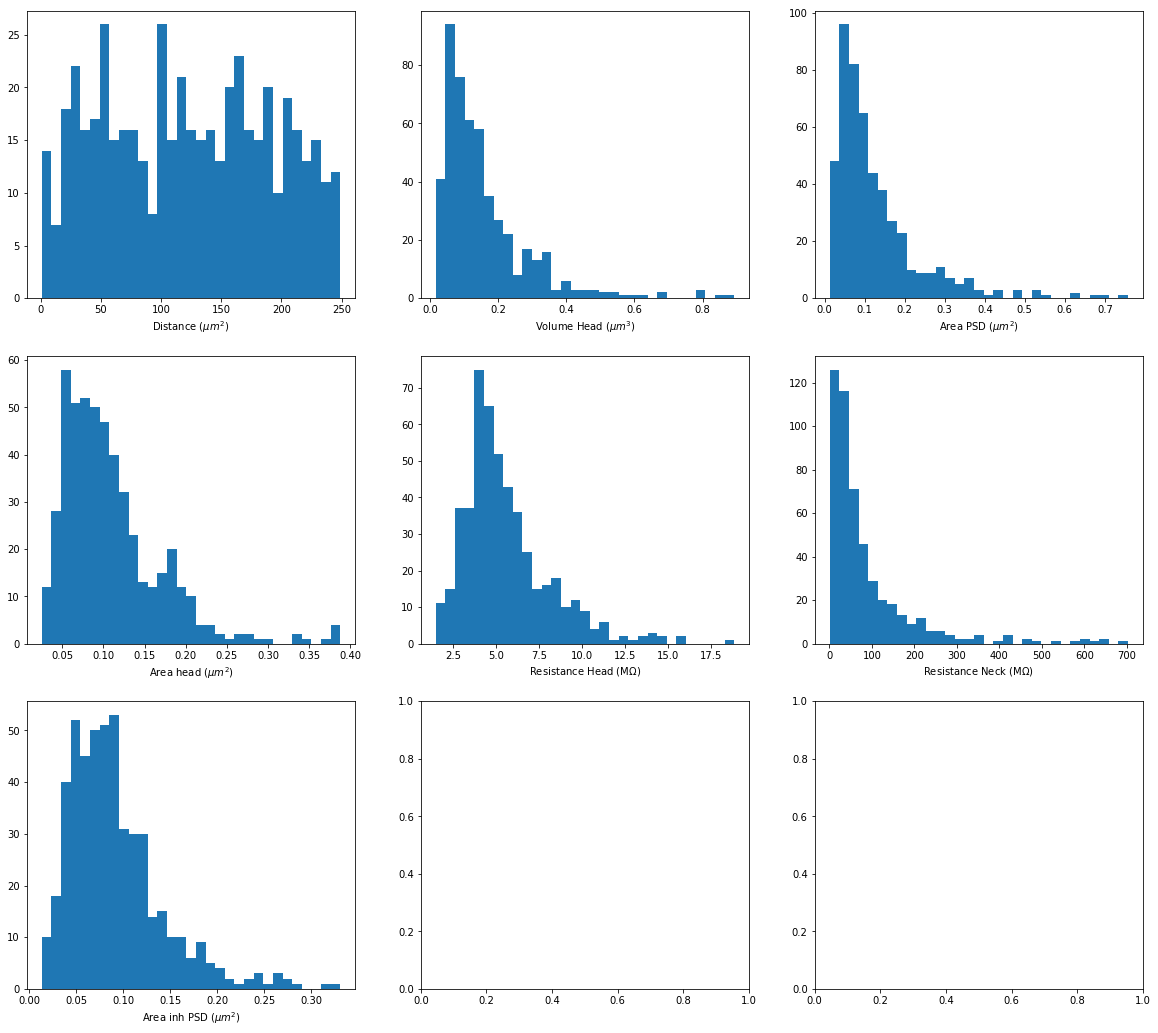

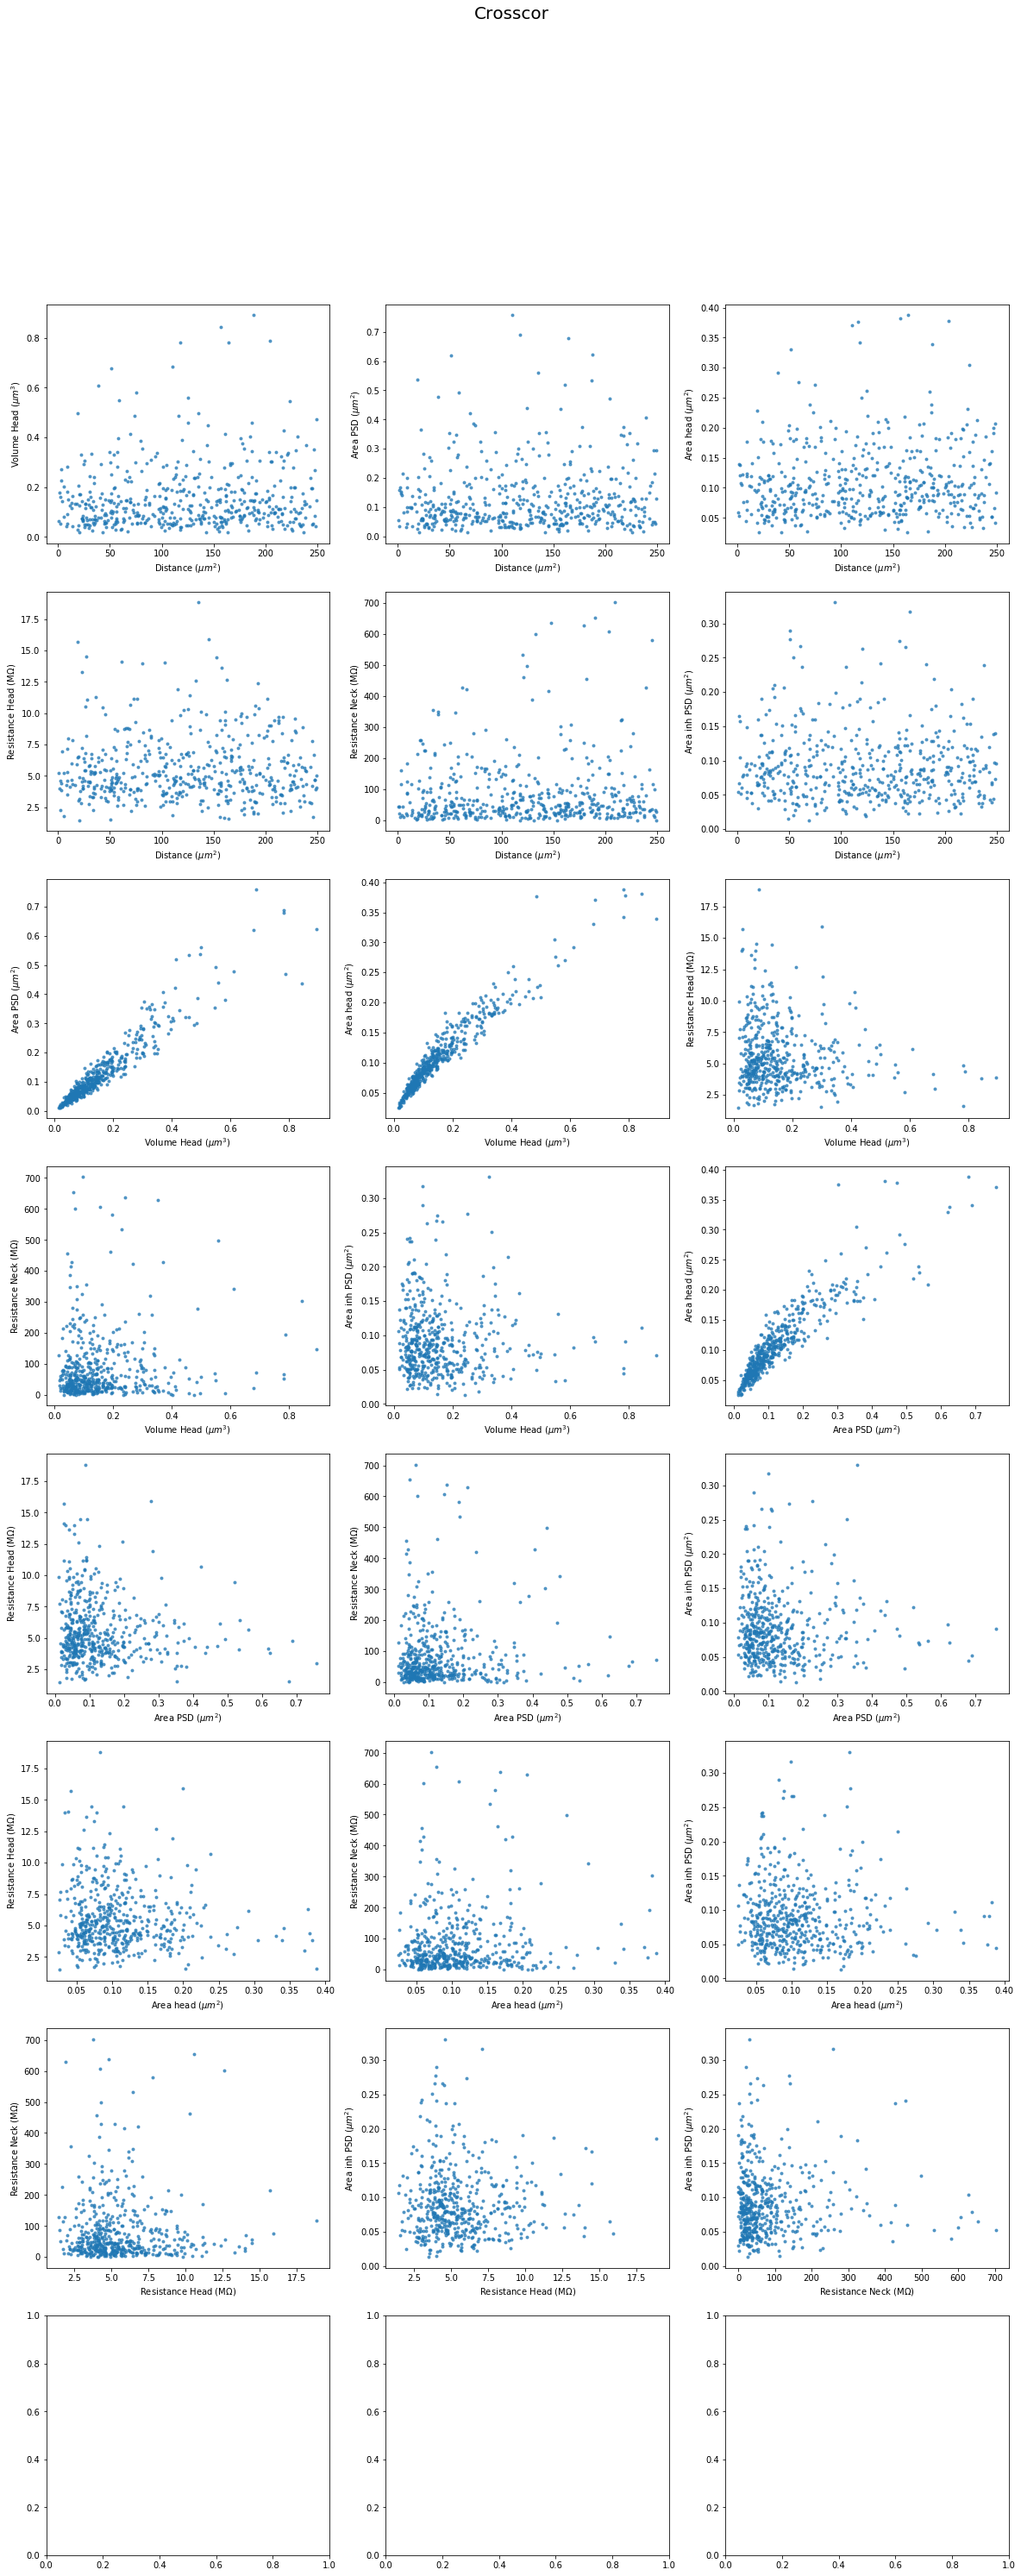

In [6]:
nsp = 500

p = data["inh shaft"]
iPSDsh = exp(randn(nsp)*p[1]+p[0])
iPSDsh = exp(randn(nsp)*p[1]+p[0])
figure()
h = hist(iPSDsh,31)
xlabel("iPSD shaft ($\mu m^2$)",fontsize=14)
#savefig("D_iPSDsh.png",bbox_inches='tight',pad_inches = 0)
#figure(figsize=(18,12))

sis,_  = generateSetSpines(nsp,data["SiS"],labels,dmethods,dclip,plot=False,corplot= False)
dis,figs = generateSetSpines(nsp,data["DiS"],labels,dmethods,dclip,plot=True,corplot= True)


Text(0.5, 0, 'I$_{max}$ (pA)')

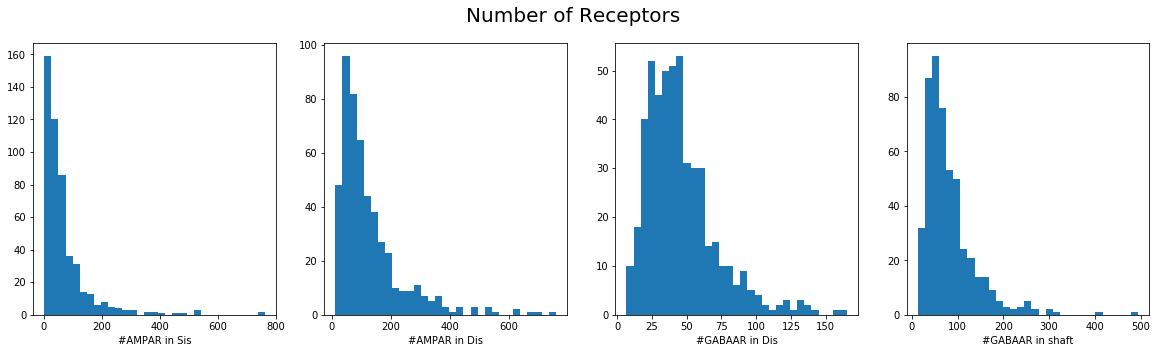

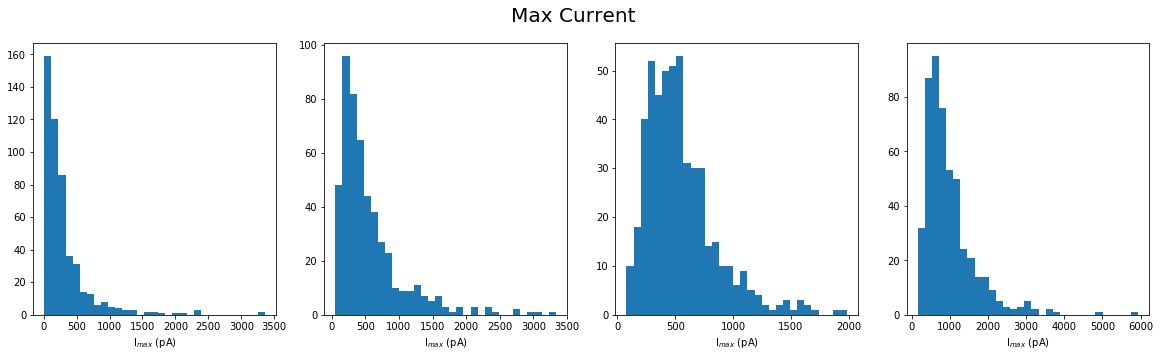

In [7]:
fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
fig.suptitle("Number of Receptors",fontsize = 20)

rhGABAR = 500 # Receptors/um2
rhAMPAR = 1000 # Receptors/um2
rhNMDAR = 10 # Receptors/um2

dDiS = data["DiS"]

ax[0].hist(sis['A1']*rhAMPAR,31)
ax[0].set_xlabel("#AMPAR in Sis")
ax[1].hist(dis['A1']*rhAMPAR,31)
ax[1].set_xlabel("#AMPAR in Dis")
ax[2].hist(dis['A2']*rhGABAR,31)
ax[2].set_xlabel("#GABAAR in Dis")
ax[3].hist(iPSDsh*rhGABAR,31)
ax[3].set_xlabel("#GABAAR in shaft")
savefig("D_nRs.png",bbox_inches='tight',pad_inches = 0)

gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*2/5.0
gtrN = rhNMDAR*30e-6/16.0

fig, ax = subplots(nrows=1,ncols=4,figsize=(20,5))
fig.suptitle("Max Current",fontsize = 20)

dDiS = data["DiS"]

ax[0].hist(sis['A1']*gtrA/1e-6,31)
ax[0].set_xlabel("I$_{max}$ (pA)")
ax[1].hist(dis['A1']*gtrA/1e-6,31)
ax[1].set_xlabel("I$_{max}$ (pA)")
ax[2].hist(dis['A2']*gtrG/1e-6,31)
ax[2].set_xlabel("I$_{max}$ (pA)")
ax[3].hist(iPSDsh*gtrG/1e-6,31)
ax[3].set_xlabel("I$_{max}$ (pA)")
#savefig("D_maxI.png",bbox_inches='tight',pad_inches = 0)


In [8]:
def fx(A,V):
    xx = 4*V/A
    yy = A**2/pi/4/V
    return(array([xx,yy]))

spn = dis
spn["D"] = zeros(nsp)
spn["L"] = zeros(nsp)
for i in arange(nsp):
    Ah = spn["Ah"][i]
    Vh = spn["Vh"][i]
    D,L = fx(Ah,Vh)
    spn["D"][i] = D
    spn["L"][i] = L
    

spn = sis
spn["D"] = zeros(nsp)
spn["L"] = zeros(nsp)
for i in arange(nsp):
    Ah = spn["Ah"][i]
    Vh = spn["Vh"][i]
    D,L = fx(Ah,Vh)
    spn["D"][i] = D
    spn["L"][i] = L

In [9]:
for dend in model.dend:
    print(dend.L,dend.diam)

1.0 1.5
200.24984394500785 1.5000000000000002
50.15974481593781 1.5
4.0 1.5
200.0 10.0


In [10]:
sp = model.spne[0]
print(sp(0.5).area(),sp(0.5).volume(),sp.diam*sp.L*pi,sp.diam**2*sp.L*pi/4.0)

sp.L = dis["L"][0]
sp.diam = dis["D"][0]
print(sp(0.5).area(),sp(0.5).volume(),dis["Ah"][0],dis["Vh"][0])


3.141592653589793 0.7853981633974483 3.141592653589793 0.7853981633974483
0.1148200997972581 0.12997957105395336 0.11482009979725812 0.12997957105395333


### Excitatory synapse 

We need to define the arrival time and dynamics. These parameters may be modified later

In [11]:
model.AMPAlist = []
model.ncAMPAlist = []

AMPA = lb.h.Exp2Syn(1,sec = model.spne[0])
tau1  = 0.5
tau2 = 3.0
AMPA.tau1 = tau1
AMPA.tau2 = tau2

nampa = 50
gmax = 15*nampa/1e6
stimE=lb.h.NetStim();stimE.number = 1; 
NC = lb.h.NetCon(stimE,AMPA,0,0,gmax)

model.AMPAlist.append(AMPA)
model.ncAMPAlist.append(NC)
NC.delay = 10

# NMDA part
nnmda = 2
gmaxN = 50*nnmda/1e6
lb.add_NMDAsyns(model, locs=[[0,0.5]], gmax=gmaxN,tau2=20.0)  
NMDA = model.NMDAlist[0]
NCN = model.ncNMDAlist[0]
stimN=lb.h.NetStim();stimN.number = 1;
NCN = lb.h.NetCon(stimN,NMDA,0,0,gmaxN)
model.ncNMDAlist[0] = NCN
NMDA.tau1 = 2.0
NMDA.tau2 = 30.0


### Inhibitory synapse

In [12]:
nGABA = 35
gmaxG = nGABA*30e-6
lb.add_GABAsyns(model, locs=[[0,1]], spne=True, gmax=gmaxG,tau1=1.5,tau2=15.0)  
GABA = model.GABAlist[0]
NCG = model.ncGABAlist[0]
stimG=lb.h.NetStim();stimG.number = 1;
NCG = lb.h.NetCon(stimG,GABA,0,0,gmaxG)
model.ncGABAlist[0] = NCG

In [13]:
#lb.init_active(model,soma=False,dend=False,dendCa=False,spne=True,dendNa=False)
#CaTcond = 2000 # pS


In [14]:
trec, vrec = lb.h.Vector(), lb.h.Vector()
gRec, iRec,  vspneRec = [], [], []
gNMDA_rec, iNMDA_rec = [], []
trec.record(lb.h._ref_t)
vrec.record(model.soma(0.5)._ref_v)


#n=0
vDendRec = []
caDendRec = []
#For all dendrites
for dend in model.dend:
    #Adding vectors for Voltage, and Calcium
    vDendRec.append(lb.h.Vector())
    caDendRec.append(lb.h.Vector())
    # Placing recording at mid-point in the dendritic branch
    vDendRec[-1].record(dend(0.5)._ref_v)
    # NO CALCIUM!?!?!
#Probably better to organize them in a dictionary        
vDendRec[1].record(model.dend[1](1.0)._ref_v)

# Spine voltage recording stuff
vspneRec.append(lb.h.Vector())
vspneRec.append(lb.h.Vector())
sp = model.spne[0]
vspneRec[0].record(sp(0.5)._ref_v)
sp = model.neck[0]
vspneRec[1].record(sp(0.5)._ref_v)

# Calcim

caDendRec = []
sp = model.spne[0]
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec.append(lb.h.Vector())
caDendRec[0].record(sp(0.5)._ref_ica) 
caDendRec[1].record(model.NMDAlist[0]._ref_i)
caDendRec[2].record(sp(1.0)._ref_cai) 


Vector[16]

In [15]:
model.dend

[dendA1c, dendA1, dendB1, DendE, DendN]

In [16]:
iRec.append(lb.h.Vector())
iRec.append(lb.h.Vector())
currentAMPA = iRec[0]
currentGABA = iRec[1]

In [17]:
currentAMPA.record(AMPA._ref_i)
currentGABA.record(GABA._ref_i)

Vector[18]

In [18]:
neck = model.neck[0]
Rneck = neck.L*1e-6/(neck.diam*1e-6/2.0)**2/pi*neck.Ra/100
dend = model.dend[0]
dend.L = dendsizeL0
dend.diam = 1.0
print(dend.L,dend.diam)
Rdend = dend.L*1e-6/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf = Rdend
dend = model.dend[1]
dendc = model.dend[1]
dendc.L = dendsizeL
dend.diam = 0.5
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
dend = model.dend[-1]
dend.diam = 0.5
dendsh = model.dend[-1]
dend.L = 5
print(dend.L,dend.diam,Rdend/1e6)
Rdend +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
Rdendf +=dend.L*1e-6/2.0/(dend.diam*1e-6/2.0)**2/pi*dend.Ra/100
print("The resistance of neck and the dendritic impedance are %.2f and %2.f MΩ (resp.)" %(Rneck,Rdend/1e6))

20.0 1.0
250.0 0.5 63.66197723675813
5.0 0.5 1655.211408155712
The resistance of neck and the dendritic impedance are 141471060.53 and 1687 MΩ (resp.)


In [19]:
#model.soma.diam = model.soma.L
dendN = model.dend[-1]

In [20]:
dendN.L = 240 

In [21]:
dendc.nseg = int(dendc.L//10)+1
dendN.nseg = int(dendN.L//10)+1

print(dendc.nseg,dendN.nseg)

26 25


In [22]:
lb.init_active(model, axon=False, soma=False, dend=False, dendNa=False,
                dendCa=False,spne=True)

## Plots

xkcd is to give it non serious appearance

In [23]:
gtrG = rhGABAR*30e-6*2/5.0
gtrA = rhAMPAR*11e-6*3/5.0
gtrN = rhNMDAR*30e-6*1.0/16.0/4.0/1.27

In [24]:
mean(spn["A1"][:])*rhNMDAR

0.7112885239707052

In [25]:
diam0 = 0.15
Rneck0 = Rneck/1e6

In [26]:
mean(gtrA*spn["A1"][:])/1e-3

0.4694504258206654

In [50]:

def simulateSet(model,spn,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = None):
    if btsr is None:
        btsr =ones(7)==1
    model.E_PAS = -65
    model.soma.e_pas = model.E_PAS
    for dendp in model.dend:
        dendp.e_pas = model.E_PAS
    for sp in model.spne:
        sp.e_pas = model.E_PAS

    dendsh = model.dend[-2]
    dendc = model.dend[1]
    dendN = model.dend[-1]
    
    data = column_stack((spn["A1"],spn["A1"],spn["A2"],spn["Rn"],spn["Dss"],dis["L"],dis["D"]))
    for i in range(7):
        if ~btsr[i]:
            data[:,i] = data[:,i].mean()
            
    mes = zeros((nsp,9))
    vavg = zeros((int(t_stop/lb.h.dt+1),7))
    vtracs = zeros((int(t_stop/lb.h.dt+1),500))
    Ctracs = zeros((int(t_stop/lb.h.dt+1),500))
    vtracsD = zeros((int(t_stop/lb.h.dt+1),500))
    vtracsS = zeros((int(t_stop/lb.h.dt+1),500))
    for i in arange(nsp):
        NC.weight[0]  = data[i,0] *gtrA#/2
        NCN.weight[0] = data[i,1] *gtrN#*0#*0
        NCG.weight[0] = data[i,2] *gtrG#*0
        
        neck.L = 1.5
        neck.diam = diam0*sqrt(Rneck0/data[i,3])
        
        posD = data[i,4]
        
        dendsh.L = 1.0
        dendc.L = posD-0.5
        dendN.L = dendsizeL-posD-0.5
        dendsh.diam = 0.5
        dendc.diam = 0.5
        dendN.diam = 0.5
        dendN.cm = 3.5
        dendc.cm = 3.5
        
        
        sp = model.spne[0]
        # A = pi*D**2
        sp.L = data[i,5]
        sp.diam = data[i,6]
        spvol = sp(0.5).volume()

        #spineArea =  spn["Ah"][i] # um^2
        #sp.gbar_itL = 5*CaTcond/spineArea*1e-10 # S/ cm^2   not pS/um^2 as in mod file
        spineArea =  sp(0.5).area()#sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        CaTcond = 2e6# pS
        sp.gbar_itL = 0.0*0.15*CaTcond/spineArea*1e-10
        sp.gbar_ca = 1.0*100*CaTcond/spineArea*1e-10
        sp.gbar_it = 0.0*0.15*CaTcond/spineArea*1e-10
        spineArea =  sp(0.5).area()
        
        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#-50

        if dendc.L>9.5:
            f = 1.0-9.5/dendc.L
            f = 0.5
            vDendRec[1].record(model.dend[1](f)._ref_v)
        else:
            vDendRec[1].record(model.dend[1](0.0)._ref_v)
        
        
        # ~ print(NC.weight[0])
        lb.h.finitialize(model.E_PAS)
        # ~ print(NC.weight[0])
        

        
        lb.neuron.run(t_stop)
        
        #plot(trec,vspneRec[0])    
        
        current = abs((array(vDendRec[1])-array(vrec[0]))/Rdend)
        
        vtracs[:,i] = array(vspneRec[0]) 
        vtracsD[:,i] = array(vDendRec[1]) 
        vtracsS[:,i] = array(vrec) 

        vavg[:,0] += array(vspneRec[0]) 
        vavg[:,1] += array(vspneRec[0])**2
        vavg[:,2] += array(vDendRec[1]) 
        vavg[:,3] += array(vDendRec[1])**2
        vavg[:,4] += array(vrec) 
        vavg[:,5] += array(vrec)**2
        vavg[:,6] += 1
            
        cat = array(caDendRec[-1])/1e-3
        Ctracs[:,i] = cat-cat[0] 
        aG = abs(array(currentGABA)).argmax()
        aA = abs(array(currentAMPA)).argmax()
        
        mes[i,:] = [data[i,3],max(vspneRec[0]),max(vDendRec[3]),max(vrec),max(cat)-cat[0],array(currentGABA)[aG],array(currentAMPA)[aA],spvol,max(current)]
        
        #plot(trec,array(caDendRec[-1])/1e-3)
        #ylabel("[Ca] (uM)")
        #figure()
        #plot(trec,vspneRec[0])
        #break
        
    vavg[:,:5] = vavg[:,:5]/vavg[0,6]
    vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
    vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
    vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])
    return(vavg,mes,vtracs,vtracsD,vtracsS,Ctracs)

In [51]:
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr = ones(7)==1)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in sqrt


In [52]:
with open("dis_baseline.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f)

In [34]:
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 500,ton = 60,toffset = 50,t_stop = 250, EL = -65,btsr = ones(7)==1)
with open("dis_baselinesh.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


In [35]:
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 0,ton = 60,toffset = 50,t_stop = 250, EL = -65,btsr = ones(7)==1)
with open("dis_ga_glu.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f)
    
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 20,ton = 60,toffset = 50,t_stop = 250, EL = -65,btsr = ones(7)==1)
with open("dis_glu_ga.pickle","wb") as f:
    pickle.dump([vavg,mes,vtracs,vtracsD,vtracsS,Ctracs],f)

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt


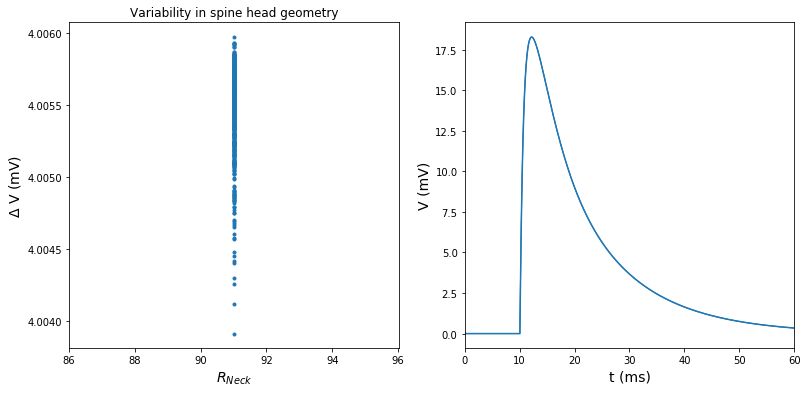

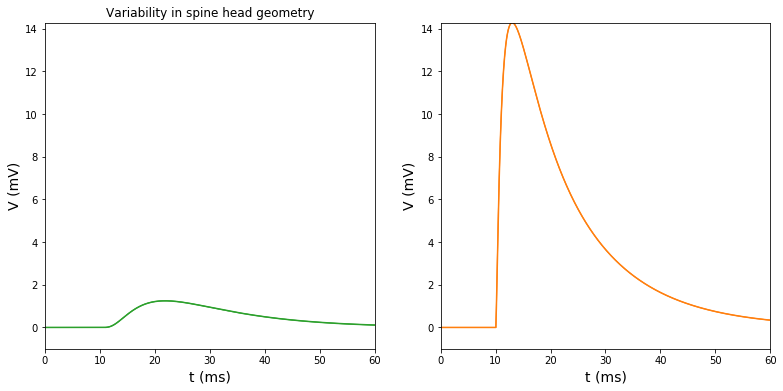

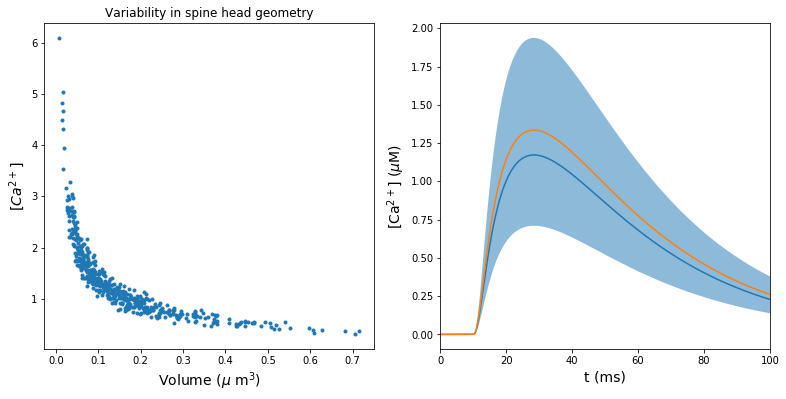

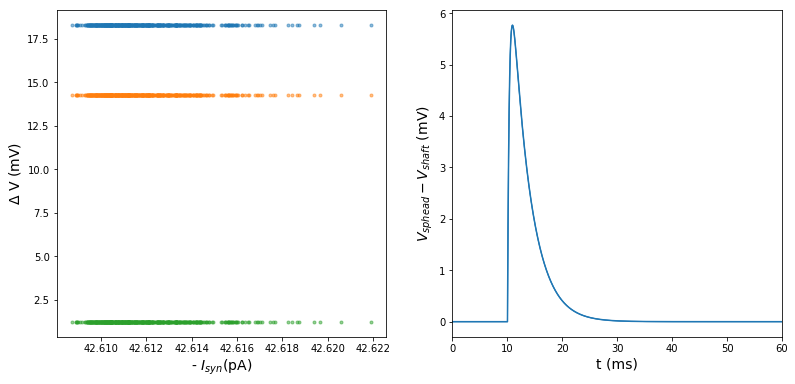

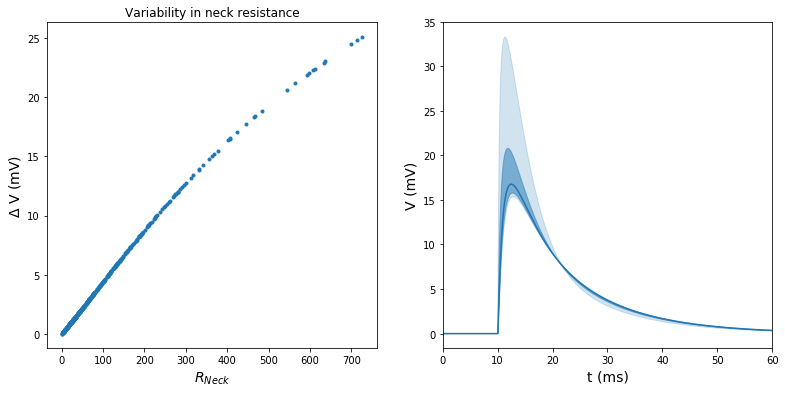

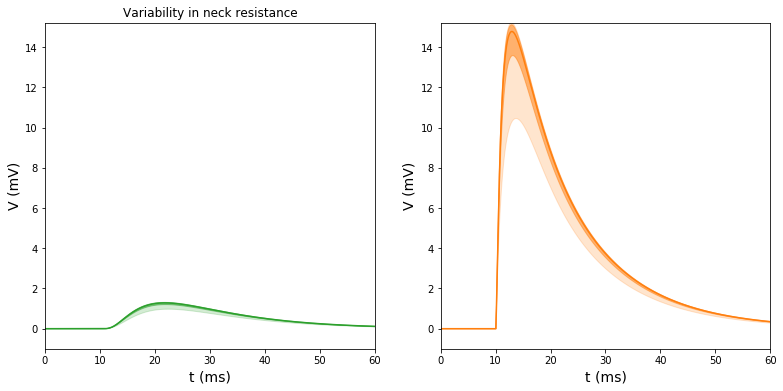

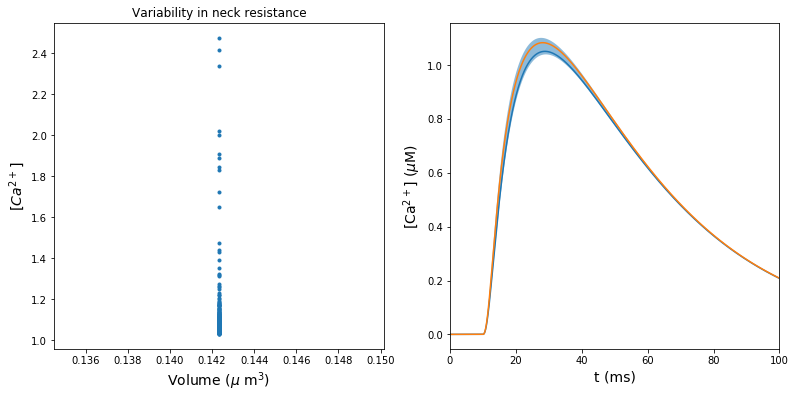

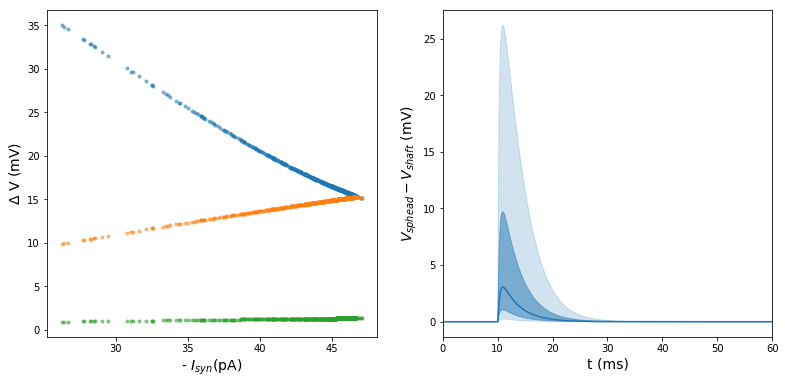

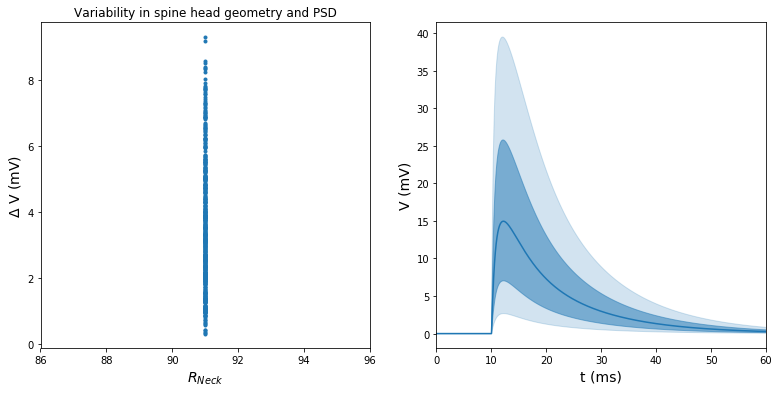

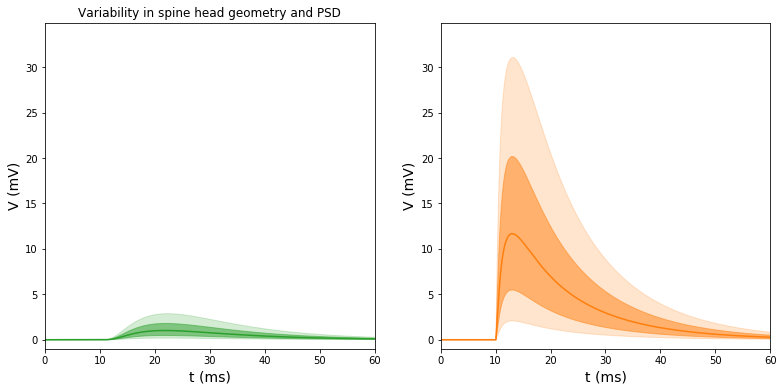

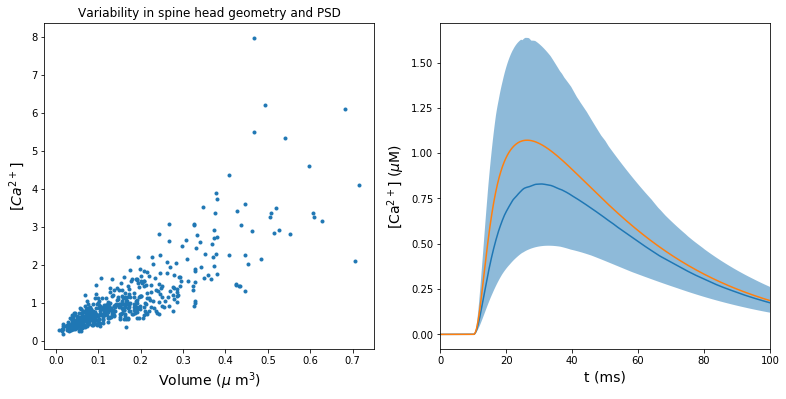

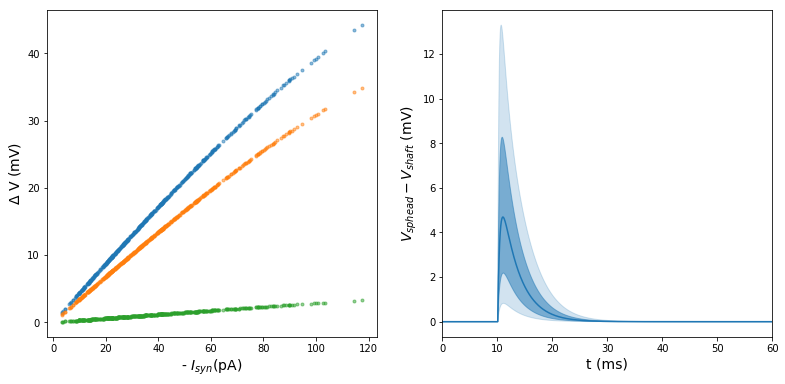

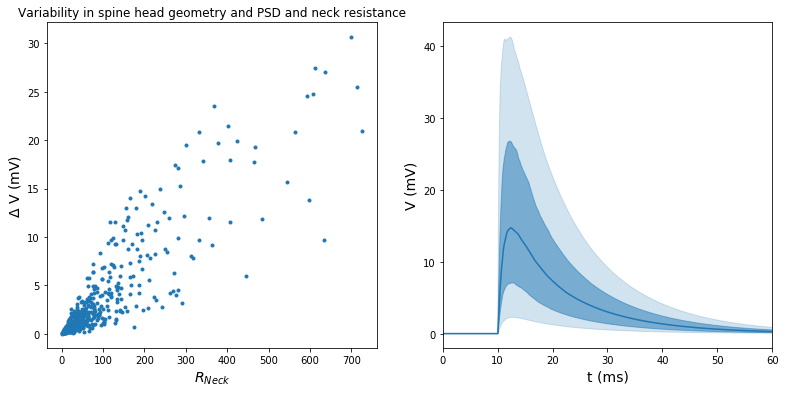

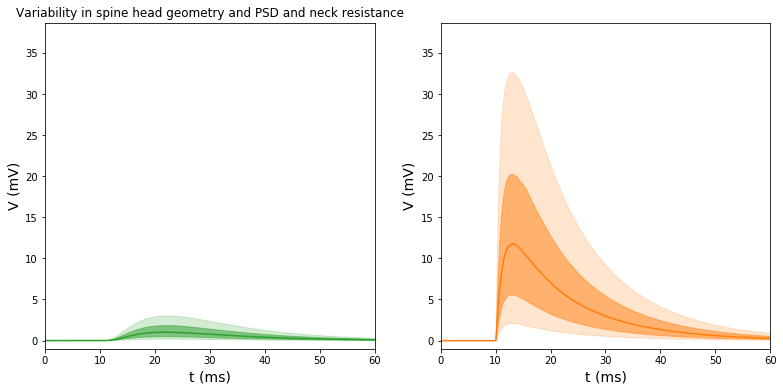

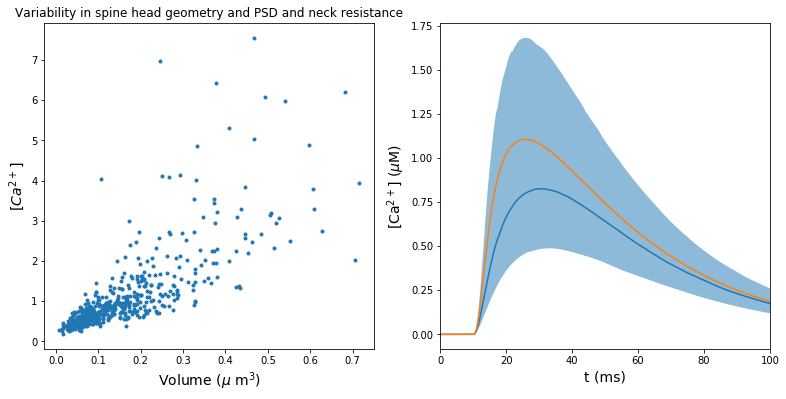

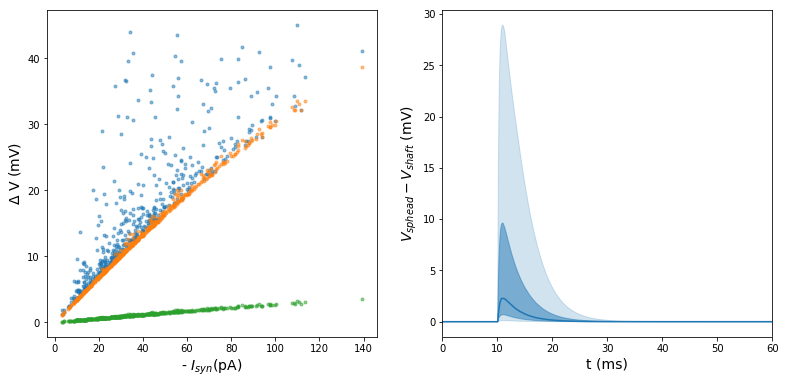

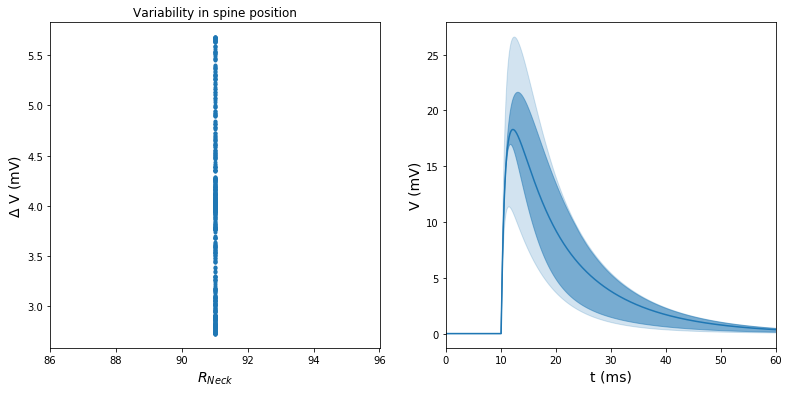

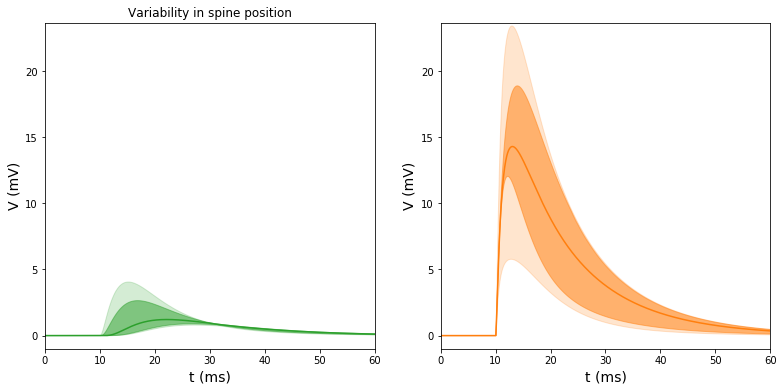

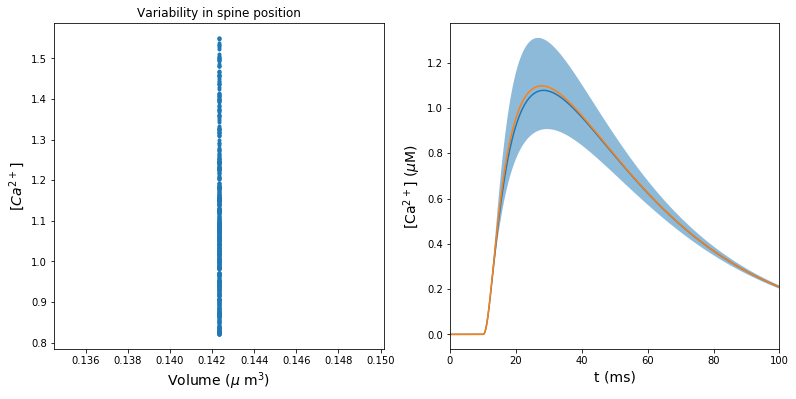

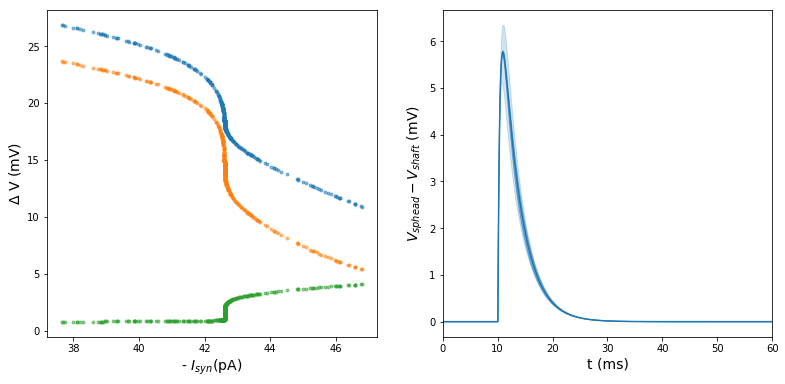

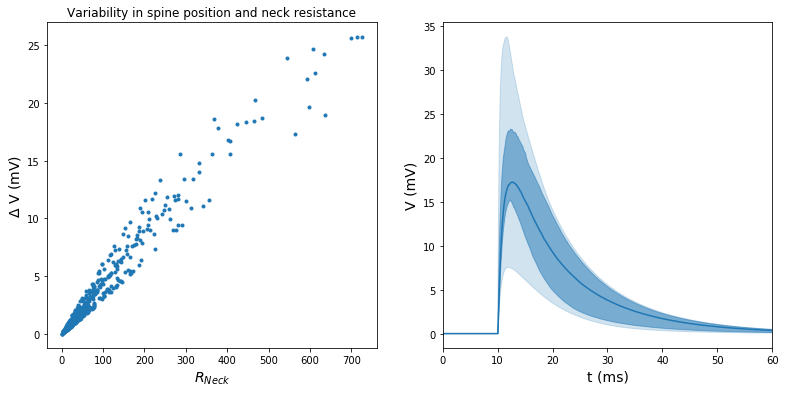

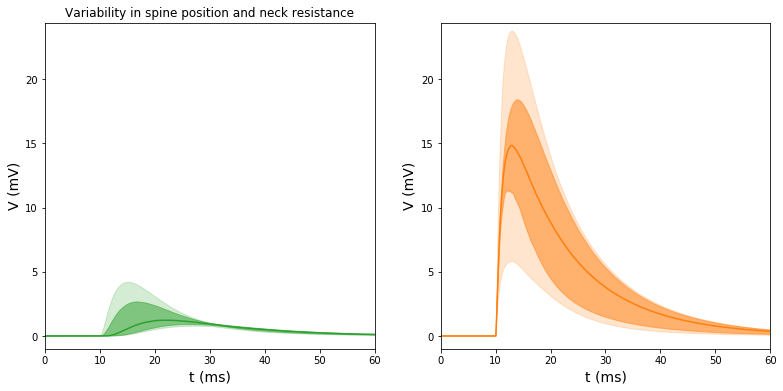

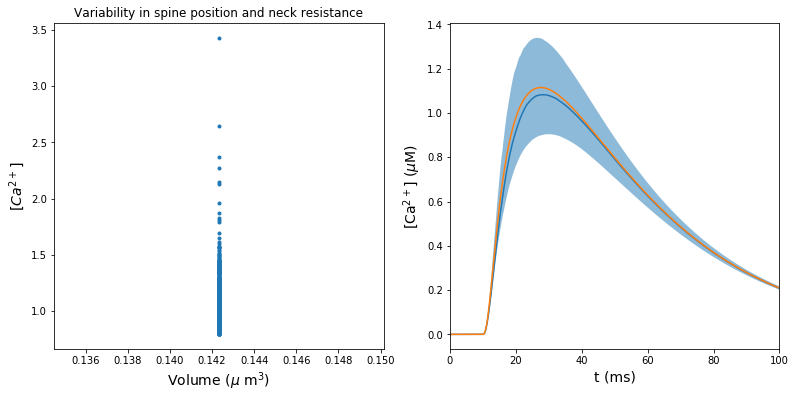

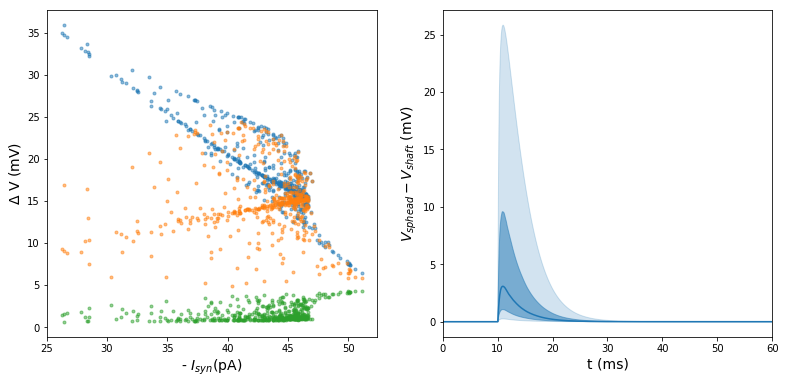

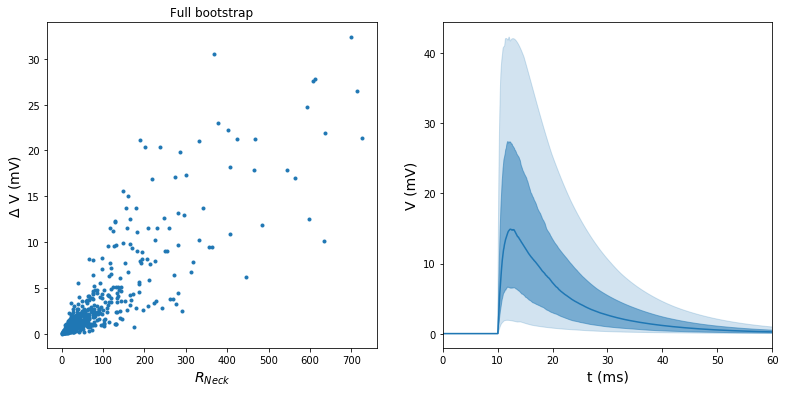

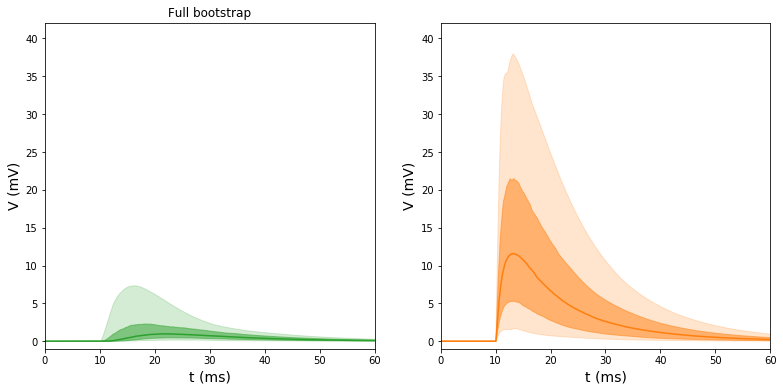

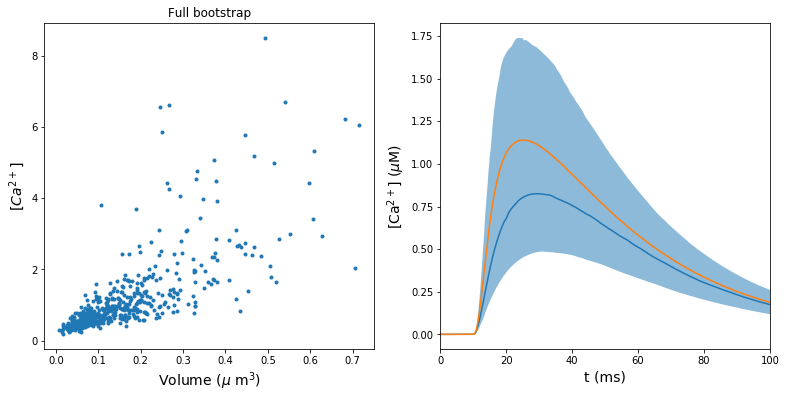

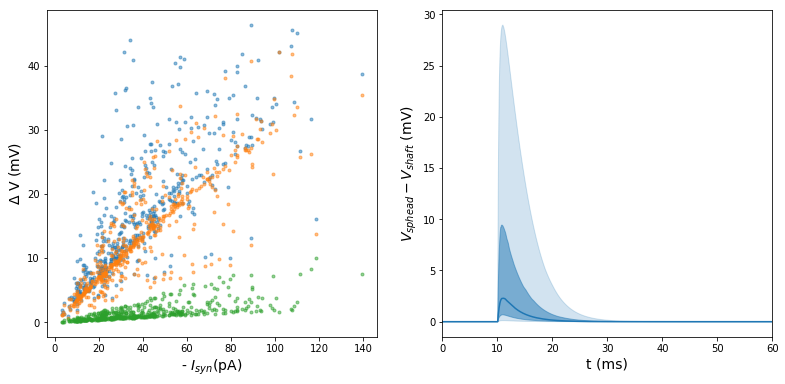

In [55]:

labelsC = ["Variability in spine head geometry",
           "Variability in neck resistance",
           "Variability in spine head geometry and PSD",
           "Variability in spine head geometry and PSD and neck resistance",
           "Variability in spine position",
           "Variability in spine position and neck resistance",
           "Full bootstrap"]
labelsCf = ["SG",
           "NR",
           "SGPSD",
           "SGPSDNR",
           "POS",
           "POSNR",
           "FULL"]

cdt = arange(7)
variabilitycs = [ (cdt==5)+(cdt==6),(cdt==3),
                 (cdt==5)+(cdt==6)+(cdt==0)+(cdt==1),
                 (cdt==5)+(cdt==6)+(cdt==0)+(cdt==1)+(cdt==3),
                 (cdt==4),(cdt==4)+(cdt==3),ones(7)==1]    
toffset = 50
ton = 50
for i in range(len(variabilitycs)):
    #i = 6
    cdt = variabilitycs[i]
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr =cdt)

    fig = figure(figsize=(13,6))
    ax = fig.add_subplot(121)

    sel = mes[:,-1].argsort()
    plot(mes[sel,0],mes[sel,1]-mes[sel,2],'.',label="Spine head")

    xlabel("$R_{Neck}$",fontsize = 14)
    ylabel("$\Delta$ V (mV)",fontsize = 14)    
    title(labelsC[i])


    ax = fig.add_subplot(122)
    vtracso = vtracs*1.0
    vtracso.sort(axis=1)
    plot(array(trec)-toffset-ton+10,vtracso[:,250]-vtracs[0,0],'C0-')
    fill_between(array(trec)-toffset-ton+10,vtracso[:,5]-vtracs[0,0],vtracso[:,495]-vtracs[0,0],color='C0',alpha=0.2)
    fill_between(array(trec)-toffset-ton+10,vtracso[:,79]-vtracs[0,0],vtracso[:,421]-vtracs[0,0],color='C0',alpha=0.5)
    xlabel("t (ms)",fontsize = 14)
    ylabel("V (mV)",fontsize = 14)
    xlim(0,60)
    savefig("FigvarV_"+labelsCf[i]+".png")
    
    fig = figure(figsize=(13,6))
    ax = fig.add_subplot(121)

    vtracso = vtracsS*1.0
    vtracso.sort(axis=1)
    plot(array(trec)-toffset-ton+10,vtracso[:,250]-vtracs[0,0],'C2-')
    fill_between(array(trec)-toffset-ton+10,vtracso[:,5]-vtracs[0,0],vtracso[:,495]-vtracs[0,0],color='C2',alpha=0.2)
    fill_between(array(trec)-toffset-ton+10,vtracso[:,79]-vtracs[0,0],vtracso[:,421]-vtracs[0,0],color='C2',alpha=0.5)
    xlabel("t (ms)",fontsize = 14)
    ylabel("V (mV)",fontsize = 14)
    xlim(0,60)
    ylim(-1,vtracsD.max()-vtracs[0,0])
    title(labelsC[i])


    ax = fig.add_subplot(122)
    vtracso = vtracsD*1.0
    vtracso.sort(axis=1)
    plot(array(trec)-toffset-ton+10,vtracso[:,250]-vtracs[0,0],'C1-')
    fill_between(array(trec)-toffset-ton+10,vtracso[:,5]-vtracs[0,0],vtracso[:,495]-vtracs[0,0],color='C1',alpha=0.2)
    fill_between(array(trec)-toffset-ton+10,vtracso[:,79]-vtracs[0,0],vtracso[:,421]-vtracs[0,0],color='C1',alpha=0.5)
    xlabel("t (ms)",fontsize = 14)
    ylabel("V (mV)",fontsize = 14)
    xlim(0,60)
    ylim(-1,vtracsD.max()-vtracs[0,0])
    savefig("FigvarV_INsD_"+labelsCf[i]+".png")
    fig = figure(figsize=(13,6))
    ax = fig.add_subplot(121)    
    title(labelsC[i])

    sel = mes[:,-1].argsort()
    plot(mes[sel,-2],mes[sel,4],'.',label="Spine head")
    #plot(mes[sel,0],mes[sel,2]+65,label="Dendritic shaft")
    #plot(mes[sel,0],mes[sel,3]+65,label="Soma")
    #yscale("log")
    xlabel("Volume ($\mu$ m$^3$)",fontsize=14)
    ylabel("$[Ca^{2+}]$",fontsize=14)

    ax = fig.add_subplot(122)
    #ax = fig.add_subplot(122)
    Co = 1.0*Ctracs
    Co.sort(axis=1)
    plot(array(trec)-toffset-ton+10,Co[:,250],label="Spine head")
    plot(array(trec)-toffset-ton+10,Co.mean(axis=1),label="Spine head")

    fill_between(array(trec)-toffset-ton+10,Co[:,79],Co[:,421],alpha=0.5)
    xlabel("t (ms)",fontsize = 14)
    ylabel("[Ca$^{2+}$] ($\mu$M)",fontsize = 14)
    xlim(0,100)
    savefig("FigvarC_"+labelsCf[i]+".png")
    #break
    
    fig = figure(figsize=(13,6))
    ax = fig.add_subplot(121)

    sel = mes[:,-3].argsort()
    plot(abs(mes[sel,-3]/1e-3),mes[sel,1]+65,'.',label="Spine head",alpha=0.5)
    plot(abs(mes[sel,-3]/1e-3),mes[sel,2]+65,'.',label="Dendritic shaft",alpha=0.5)
    plot(abs(mes[sel,-3]/1e-3),mes[sel,3]+65,'.',label="Soma",alpha=0.5)

    xlabel("- $I_{syn}$(pA)",fontsize = 14)
    ylabel("$\Delta$ V (mV)",fontsize = 14)

    vtracso = vtracs-vtracsD

    vtracso.sort(axis=1)

    ax = fig.add_subplot(122)
    plot(array(trec)-toffset-ton+10,vtracso[:,250],'C0-')
    fill_between(array(trec)-toffset-ton+10,vtracso[:,5],vtracso[:,495],color='C0',alpha=0.2)
    fill_between(array(trec)-toffset-ton+10,vtracso[:,79],vtracso[:,421],color='C0',alpha=0.5)
    xlabel("t (ms)",fontsize = 14)
    ylabel("$V_{sp head}-V_{shaft}$ (mV)",fontsize = 14)
    xlim(0,60)

    savefig("FigvarV2"+labelsCf[i]+".png",bbox_inches='tight',pad_inches = 0)


In [ ]:
#i = 6
i = 0
cdt = variabilitycs[i]
vavg,mes,vtracs,vtracsD,vtracsS,Ctracs = simulateSet(model,dis,tG = 500,ton = 50,toffset = 50,t_stop = 250, EL = -65,btsr =cdt)

(0, 100)

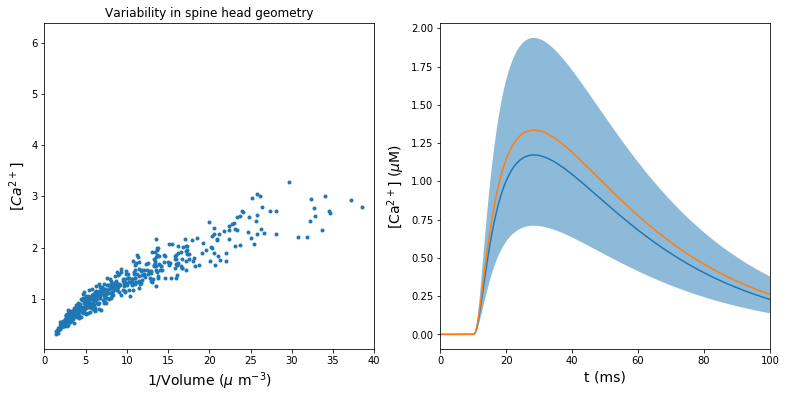

In [48]:
fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)    
title(labelsC[i])

sel = mes[:,-1].argsort()
plot(1.0/mes[sel,-2],mes[sel,4],'.',label="Spine head")
#plot(mes[sel,0],mes[sel,2]+65,label="Dendritic shaft")
#plot(mes[sel,0],mes[sel,3]+65,label="Soma")
#yscale("log")
xlabel("1/Volume ($\mu$ m$^{-3}$)",fontsize=14)
ylabel("$[Ca^{2+}]$",fontsize=14)
xlim(0,40)
ax = fig.add_subplot(122)
#ax = fig.add_subplot(122)
Co = 1.0*Ctracs
Co.sort(axis=1)
plot(array(trec)-toffset-ton+10,Co[:,250],label="Spine head")
plot(array(trec)-toffset-ton+10,Co.mean(axis=1),label="Spine head")

fill_between(array(trec)-toffset-ton+10,Co[:,79],Co[:,421],alpha=0.5)
xlabel("t (ms)",fontsize = 14)
ylabel("[Ca$^{2+}$] ($\mu$M)",fontsize = 14)
xlim(0,100)

In [20]:
dend.Ra = 250
neck.Ra = 250
model.E_PAS = -65
model.soma.e_pas = -65
for dendp in model.dend:
    dendp.e_pas = -65
for sp in model.spne:
    sp.e_pas = -65


#rinh = 5.0
    
#tsGABA = cumsum(-log(rand(10))/rinh)*1000

#print(tsGABA)

#selG = abs(tsGABA-ton).argmin()


ton = 50

toffset = 50

tG = ton+10

spn = dis

gA1ampa = 11/1e6

t_stop = 250
mes = zeros((nsp,6))
vavg = zeros((int(t_stop/lb.h.dt+1),7))
vtracs = zeros((int(t_stop/lb.h.dt+1),500))
Ctracs = zeros((int(t_stop/lb.h.dt+1),500))

for i in arange(nsp):
    #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)

    NC.weight[0] = spn["A1"][i] *gtrA#/2
    NCN.weight[0] = spn["A1"][i] *gtrN#*0#*0
    NCG.weight[0] = spn["A2"][i] *gtrG#*0

    
    neck.Ra = spn["Rn"][i]/Rneck
    #neck.L = 1.5
    #Rneckt = Rneck*Ra/250
    #dend.L = spn["Dss"][i]*2
    posD = spn["Dss"][i]/dendsizeL
    #posG = 0.5+randn()*2.0/position
    dendsh.connect(dendc,posD,0.)

    
    sp = model.spne[0]
    # A = pi*D**2
    sp.L =  spn["D"][i]
    sp.diam = spn["L"][i]

    #spineArea =  spn["Ah"][i] # um^2
    #sp.gbar_itL = 5*CaTcond/spineArea*1e-10 # S/ cm^2   not pS/um^2 as in mod file
    spineArea =  sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
    CaTcond = 2e6# pS
    sp.gbar_itL = 0.0*0.15*CaTcond/spineArea*1e-10
    sp.gbar_ca = 1.0*100*CaTcond/spineArea*1e-10
    sp.gbar_it = 0.0*0.15*CaTcond/spineArea*1e-10
    spineArea =  sp.L*sp.diam*pi+pi*sp.diam**2/4 # um^2
    
    tG = 10

    NC.delay = toffset+ton-50
    NCN.delay = toffset+ton-50
    NCG.delay = toffset+tG#-50

    
    # ~ print(NC.weight[0])
    lb.h.finitialize(model.E_PAS)
    # ~ print(NC.weight[0])
    
    lb.neuron.run(t_stop)
    
    #plot(trec,vspneRec[0])    
    
    current = abs((array(vDendRec[-2])-array(vDendRec[0]))/Rdend)
    
    vtracs[:,i] = array(vspneRec[0]) 
    vavg[:,0] += array(vspneRec[0]) 
    vavg[:,1] += array(vspneRec[0])**2
    vavg[:,2] += array(vDendRec[0]) 
    vavg[:,3] += array(vDendRec[0])**2
    vavg[:,4] += array(vrec) 
    vavg[:,5] += array(vrec)**2
    vavg[:,6] += 1
        
    cat = array(caDendRec[-1])/1e-3
    Ctracs[:,i] = cat-cat[0] 

    mes[i,:] = [nampa,max(vspneRec[0]),max(vDendRec[3]),max(vrec),max(cat)-cat[0],max(current)]
    
    #plot(trec,array(caDendRec[-1])/1e-3)
    #ylabel("[Ca] (uM)")
    #figure()
    #plot(trec,vspneRec[0])
    #break
    
vavg[:,:5] = vavg[:,:5]/vavg[0,6]
vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt


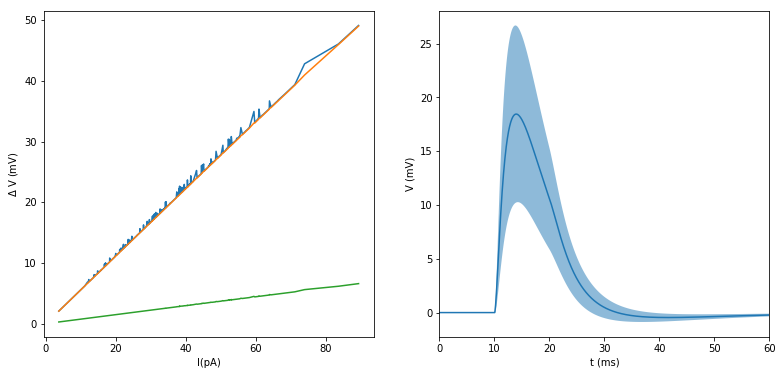

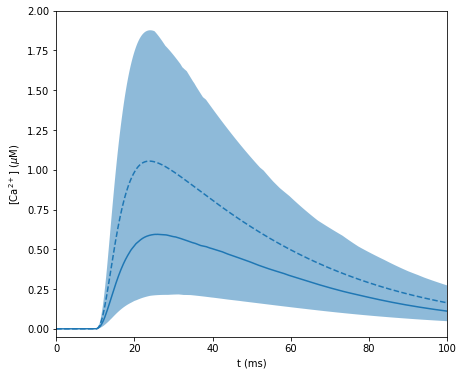

In [21]:
fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)

sel = mes[:,-1].argsort()
plot(mes[sel,-1]/1e-12,mes[sel,1]+65,label="Spine head")
plot(mes[sel,-1]/1e-12,mes[sel,2]+65,label="Dendritic shaft")
plot(mes[sel,-1]/1e-12,mes[sel,3]+65,label="Soma")

xlabel("I(pA)")
ylabel("$\Delta$ V (mV)")

ax = fig.add_subplot(122)
vavt = vavg[:,:2]*1.0
vavt[:,0] = vavg[:,0]-vavg[0,0] 
plot(array(trec)-toffset-ton+10,vavt[:,0]-vavt[0,0],label="Spine head")
fill_between(array(trec)-toffset-ton+10,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1],alpha=0.5)
xlabel("t (ms)")
ylabel("V (mV)")
xlim(0,60)
#savefig("FigEI_pos10.png",bbox_inches='tight',pad_inches = 0)

figure(figsize=(7,6))
#ax = fig.add_subplot(122)
Co = 1.0*Ctracs
Co.sort(axis=1)
plot(array(trec)-toffset-ton+10,Co[:,250],label="Spine head")
plot(array(trec)-toffset-ton+10,Co.mean(axis=1),'C0--',label="Spine head")

fill_between(array(trec)-toffset-ton+10,Co[:,79],Co[:,421],alpha=0.5)
xlabel("t (ms)")
ylabel("[Ca$^{2+}$] ($\mu$M)")
ylim(-0.05,2.)
xlim(0,100)
savefig("FigCa_pos10.png",bbox_inches='tight',pad_inches = 0)

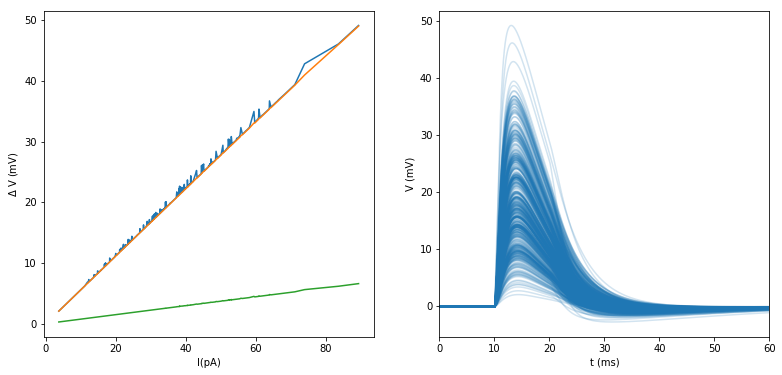

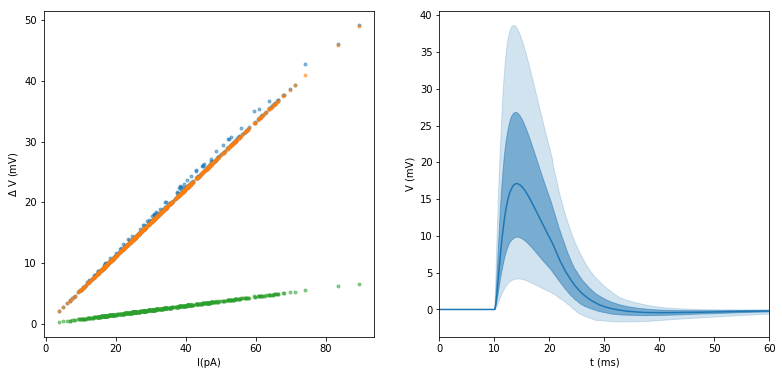

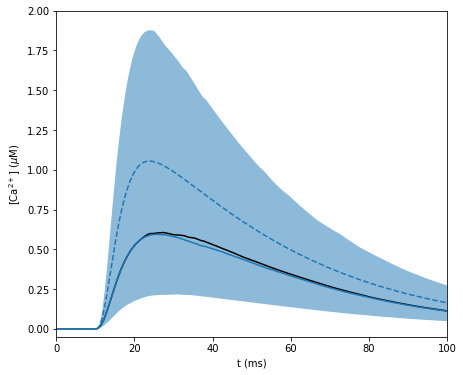

In [22]:
fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)

sel = mes[:,-1].argsort()
plot(mes[sel,-1]/1e-12,mes[sel,1]+65,label="Spine head")
plot(mes[sel,-1]/1e-12,mes[sel,2]+65,label="Dendritic shaft")
plot(mes[sel,-1]/1e-12,mes[sel,3]+65,label="Soma")

xlabel("I(pA)")
ylabel("$\Delta$ V (mV)")

ax = fig.add_subplot(122)
for i in permutation(arange(nsp))[:500]:
    plot(array(trec)-toffset-ton+10,vtracs[:,i]-vtracs[0,i],'C0-',alpha=0.2)
#fill_between(array(trec)-toffset-ton+10,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
xlabel("t (ms)")
ylabel("V (mV)")
xlim(0,60)
#savefig("FigEI_pos10.pdf")

fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)

sel = mes[:,-1].argsort()
plot(mes[sel,-1]/1e-12,mes[sel,1]+65,'.',label="Spine head",alpha=0.5)
plot(mes[sel,-1]/1e-12,mes[sel,2]+65,'.',label="Dendritic shaft",alpha=0.5)
plot(mes[sel,-1]/1e-12,mes[sel,3]+65,'.',label="Soma",alpha=0.5)

xlabel("I(pA)")
ylabel("$\Delta$ V (mV)")

vtracso = vtracs*1.0

vtracso.sort(axis=1)

ax = fig.add_subplot(122)
plot(array(trec)-toffset-ton+10,vtracso[:,250]-vtracs[0,0],'C0-')
fill_between(array(trec)-toffset-ton+10,vtracso[:,5]-vtracs[0,0],vtracso[:,495]-vtracs[0,0],color='C0',alpha=0.2)
fill_between(array(trec)-toffset-ton+10,vtracso[:,79]-vtracs[0,0],vtracso[:,421]-vtracs[0,0],color='C0',alpha=0.5)
xlabel("t (ms)")
ylabel("V (mV)")
xlim(0,60)
savefig("FigEI_pos10.png",bbox_inches='tight',pad_inches = 0)

figure(figsize=(7,6))
#ax = fig.add_subplot(122)
Co = 1.0*Ctracs
Co.sort(axis=1)
plot(array(trec)-toffset-ton+10,xxo,'k-',label="Spine head")
plot(array(trec)-toffset-ton+10,Co[:,250],label="Spine head")
plot(array(trec)-toffset-ton+10,Co.mean(axis=1),'C0--',label="Spine head")
#fill_between(array(trec)-toffset-ton+10,Co[:,5],Co[:,495],alpha=0.5)
fill_between(array(trec)-toffset-ton+10,Co[:,79],Co[:,421],alpha=0.5)
xlabel("t (ms)")
ylabel("[Ca$^{2+}$] ($\mu$M)")
xlim(0,100)
ylim(-0.05,2.)
savefig("FigCa_pos10.png",bbox_inches='tight',pad_inches = 0)

In [23]:
dend.Ra = 250
neck.Ra = 250
model.E_PAS = -65
model.soma.e_pas = -65
for dendp in model.dend:
    dendp.e_pas = -65
for sp in model.spne:
    sp.e_pas = -65
    
#rinh = 5.0
    
#tsGABA = cumsum(-log(rand(10))/rinh)*1000

#print(tsGABA)

#selG = abs(tsGABA-ton).argmin()


ton = 50

toffset = 50

tG = ton+10

spn = dis

gA1ampa = 11/1e6

t_stop = 250
mes = zeros((nsp,6))
vavg = zeros((int(t_stop/lb.h.dt+1),7))
vtracs = zeros((int(t_stop/lb.h.dt+1),500))
Ctracs = zeros((int(t_stop/lb.h.dt+1),500))

for i in arange(nsp):
    #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)

    NC.weight[0] = spn["A1"][i] *gtrA#/2
    NCN.weight[0] = spn["A1"][i] *gtrN#*0#*0
    NCG.weight[0] = spn["A2"][i] *gtrG#*0

    
    neck.Ra = spn["Rn"][i]/Rneck
    #neck.L = 1.5
    #Rneckt = Rneck*Ra/250
    #dend.L = spn["Dss"][i]*2
    posD = spn["Dss"][i]/dendsizeL
    #posG = 0.5+randn()*2.0/position
    dendsh.connect(dendc,posD,0.)

    
    sp = model.spne[0]
    # A = pi*D**2
    sp.L =  spn["D"][i]
    sp.diam = spn["L"][i]

    #spineArea =  spn["Ah"][i] # um^2
    #sp.gbar_itL = 5*CaTcond/spineArea*1e-10 # S/ cm^2   not pS/um^2 as in mod file
    spineArea =  sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
    CaTcond = 2e6# pS
    sp.gbar_itL = 0.0*0.15*CaTcond/spineArea*1e-10
    sp.gbar_ca = 1.0*100*CaTcond/spineArea*1e-10
    sp.gbar_it = 0.0*0.15*CaTcond/spineArea*1e-10
    spineArea =  sp.L*sp.diam*pi+pi*sp.diam**2/4 # um^2
    #spineArea =  spn["Ah"][i] # um^2
    #sp.gbar_itL = 5*CaTcond/spineArea*1e-10 # S/ cm^2   not pS/um^2 as in mod file

    
    tG = -10

    NC.delay = toffset+ton-50
    NCN.delay = toffset+ton-50
    NCG.delay = toffset+tG#-50

    
    # ~ print(NC.weight[0])
    lb.h.finitialize(model.E_PAS)
    # ~ print(NC.weight[0])
    
    lb.neuron.run(t_stop)
    
    #plot(trec,vspneRec[0])    
    
    current = abs((array(vDendRec[-2])-array(vDendRec[0]))/Rdend)
    
    vtracs[:,i] = array(vspneRec[0]) 
    vavg[:,0] += array(vspneRec[0]) 
    vavg[:,1] += array(vspneRec[0])**2
    vavg[:,2] += array(vDendRec[0]) 
    vavg[:,3] += array(vDendRec[0])**2
    vavg[:,4] += array(vrec) 
    vavg[:,5] += array(vrec)**2
    vavg[:,6] += 1
        
    cat = array(caDendRec[-1])/1e-3
    Ctracs[:,i] = cat-cat[0] 

    mes[i,:] = [nampa,max(vspneRec[0]),max(vDendRec[1]),max(vrec),max(cat)-cat[0],max(current)]
    
    #plot(trec,array(caDendRec[-1])/1e-3)
    #ylabel("[Ca] (uM)")
    #figure()
    #plot(trec,vspneRec[0])
    #break
    
vavg[:,:5] = vavg[:,:5]/vavg[0,6]
vavg[:,1] = sqrt(vavg[:,1]-vavg[:,0]**2)#/sqrt(vavg[0,6])
vavg[:,3] = sqrt(vavg[:,3]-vavg[:,2]**2)#/sqrt(vavg[0,6])
vavg[:,5] = sqrt(vavg[:,5]-vavg[:,4]**2)#/sqrt(vavg[0,6])

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in sqrt
/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in sqrt


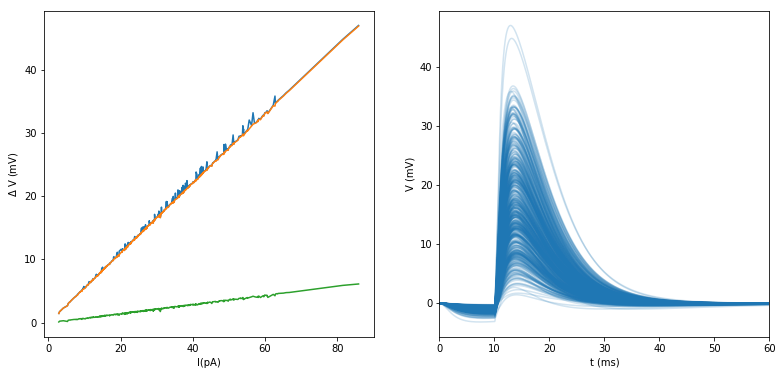

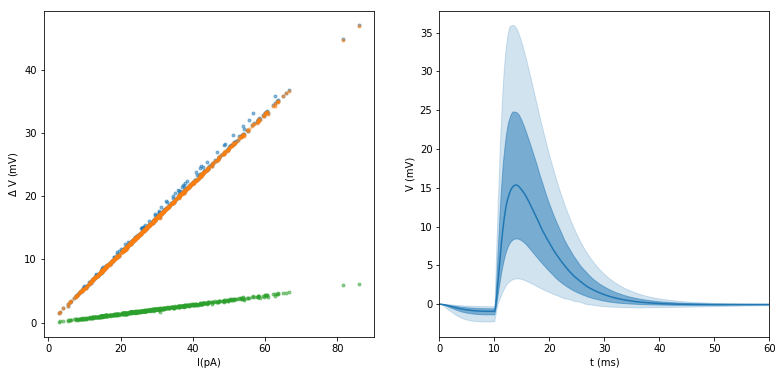

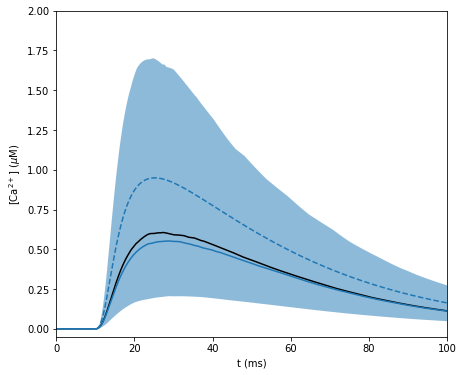

In [24]:
fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)

sel = mes[:,-1].argsort()
plot(mes[sel,-1]/1e-12,mes[sel,1]+65,label="Spine head")
plot(mes[sel,-1]/1e-12,mes[sel,2]+65,label="Dendritic shaft")
plot(mes[sel,-1]/1e-12,mes[sel,3]+65,label="Soma")

xlabel("I(pA)")
ylabel("$\Delta$ V (mV)")

ax = fig.add_subplot(122)
for i in permutation(arange(nsp))[:500]:
    plot(array(trec)-toffset-ton+10,vtracs[:,i]-vtracs[0,i],'C0-',alpha=0.2)
#fill_between(array(trec)-toffset-ton+10,vavt[:,0]+vavt[:,1],vavt[:,0]-vavt[:,1])
xlabel("t (ms)")
ylabel("V (mV)")
xlim(0,60)
#savefig("FigEI_pos10.pdf")

fig = figure(figsize=(13,6))
ax = fig.add_subplot(121)

sel = mes[:,-1].argsort()
plot(mes[sel,-1]/1e-12,mes[sel,1]+65,'.',label="Spine head",alpha=0.5)
plot(mes[sel,-1]/1e-12,mes[sel,2]+65,'.',label="Dendritic shaft",alpha=0.5)
plot(mes[sel,-1]/1e-12,mes[sel,3]+65,'.',label="Soma",alpha=0.5)

xlabel("I(pA)")
ylabel("$\Delta$ V (mV)")

vtracso = vtracs*1.0

vtracso.sort(axis=1)

ax = fig.add_subplot(122)
plot(array(trec)-toffset-ton+10,vtracso[:,250]-vtracs[0,0],'C0-')
fill_between(array(trec)-toffset-ton+10,vtracso[:,5]-vtracs[0,0],vtracso[:,495]-vtracs[0,0],color='C0',alpha=0.2)
fill_between(array(trec)-toffset-ton+10,vtracso[:,79]-vtracs[0,0],vtracso[:,421]-vtracs[0,0],color='C0',alpha=0.5)
xlabel("t (ms)")
ylabel("V (mV)")
xlim(0,60)
savefig("FigEI_pre10.png",bbox_inches='tight',pad_inches = 0)
figure(figsize=(7,6))
#ax = fig.add_subplot(122)
Co = 1.0*Ctracs
Co.sort(axis=1)
plot(array(trec)-toffset-ton+10,xxo,'k-',label="Spine head")
plot(array(trec)-toffset-ton+10,Co[:,250],label="Spine head")
plot(array(trec)-toffset-ton+10,Co.mean(axis=1),'C0--',label="Spine head")
#fill_between(array(trec)-toffset-ton+10,Co[:,5],Co[:,495],alpha=0.5)
fill_between(array(trec)-toffset-ton+10,Co[:,79],Co[:,421],alpha=0.5)
xlabel("t (ms)")
ylabel("[Ca$^{2+}$] ($\mu$M)")
xlim(0,100)
ylim(-.05,2)
savefig("FigCa_pre10.png",bbox_inches='tight',pad_inches = 0)

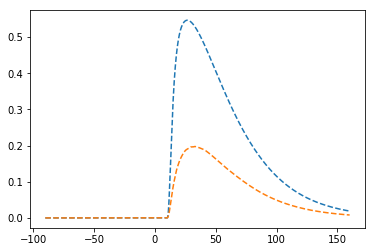

In [24]:
plot(array(trec)-toffset-ton+10,Co.mean(axis=1),'C0--',label="Spine head")
plot(array(trec)-toffset-ton+10,Co[:,140],'C1--',label="Spine head")


In [25]:
dis.keys()

dict_keys(['Dss', 'Vh', 'A1', 'Ah', 'Rh', 'Rn', 'A2', 'nsp', 'D', 'L'])

In [25]:
def delinh(tG,spn,EL = -65,toffset = 50):
    ''' tG: delay of inhibition 
        spn: dictionary with spines properties
    '''
    model.E_PAS = EL
    model.soma.e_pas = EL
    for dendp in model.dend:
        dendp.e_pas = EL
    for sp in model.spne:
        sp.e_pas = EL

    ton = 50
    t_stop = 250
    nsp = spn["nsp"]
    
    mes = zeros((nsp,6))
    vtracs = zeros((int(t_stop/lb.h.dt+1),500))
    Ctracs = zeros((int(t_stop/lb.h.dt+1),500))
    for i in arange(nsp):
        #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)

        NC.weight[0] = spn["A1"][i] *gtrA#/2
        NCN.weight[0] = spn["A1"][i] *gtrN#*0#*0
        NCG.weight[0] = spn["A2"][i] *gtrG#*0


        neck.Ra = spn["Rn"][i]/Rneck
        #neck.L = 1.5
        #Rneckt = Rneck*Ra/250
        #dend.L = spn["Dss"][i]*2
        posD = spn["Dss"][i]/dendsizeL
        #posG = 0.5+randn()*2.0/position
        dendsh.connect(dendc,posD,0.)


        sp = model.spne[0]
        # A = pi*D**2
        sp.L =  spn["D"][i]
        sp.diam = spn["L"][i]

        #spineArea =  spn["Ah"][i] # um^2
        #sp.gbar_itL = 5*CaTcond/spineArea*1e-10 # S/ cm^2   not pS/um^2 as in mod file
        spineArea =  sp.L*sp.diam+1.8*sp.diam**2/4 # um^2
        CaTcond = 2e6# pS
        sp.gbar_itL = 0.0*0.15*CaTcond/spineArea*1e-10
        sp.gbar_ca = 1.0*100*CaTcond/spineArea*1e-10
        sp.gbar_it = 0.0*0.15*CaTcond/spineArea*1e-10
        spineArea =  sp.L*sp.diam*pi+pi*sp.diam**2/4 # um^2

        NC.delay = toffset+ton-50
        NCN.delay = toffset+ton-50
        NCG.delay = toffset+tG#-50

        # ~ print(NC.weight[0])
        lb.h.finitialize(model.E_PAS)
        # ~ print(NC.weight[0])

        lb.neuron.run(t_stop)

        #plot(trec,vspneRec[0])    

        current = abs((array(vDendRec[-2])-array(vDendRec[0]))/Rdend)

        vtracs[:,i] = array(vspneRec[0]) 
        
        cat = array(caDendRec[-1])/1e-3

        Ctracs[:,i] = cat-cat[0] 

        mes[i,:] = [nampa,max(vspneRec[0])-EL,max(vDendRec[1])-EL,max(vrec)-EL,max(cat)-cat[0],max(current)]
    
    vtracso = vtracs*1.0
    vtracso.sort(axis=1)
    vmed = vtracso[:,250]-EL
    v2s = column_stack((vtracso[:,5]-EL,vtracso[:,495]-EL))
    v1s = column_stack((vtracso[:,79]-EL,vtracso[:,421]-EL))
    Ctracso = Ctracs*1.0
    Ctracso.sort(axis=1)
    Cmed = Ctracso[:,250]
    C2s = column_stack((Ctracso[:,5],vtracso[:,495]))
    C1s = column_stack((Ctracso[:,79],vtracso[:,421]))

    vs = column_stack((vmed,v1s,v2s,vtracs.mean(axis=1)))
    Cs = column_stack((Cmed,C1s,C2s,Ctracs.mean(axis=1)))

    return(vs,mes,Cs)


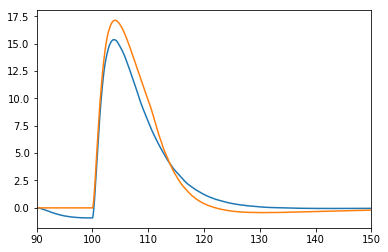

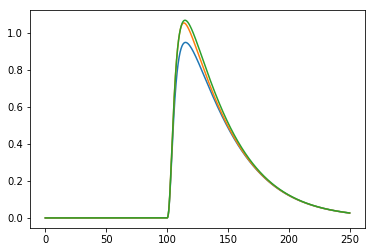

In [26]:
vm0,mes0,C1 = delinh(-10,dis)
plot(trec,vm0[:,0])
vm0,mes0,C2 = delinh(10,dis)
plot(trec,vm0[:,0])
vm0,mes0,C3 = delinh(200,dis)

xlim(90,150)
figure()
plot(trec,C1[:,-1])
plot(trec,C2[:,-1])
plot(trec,C3[:,-1])

In [27]:
vaF = {}
meF = {}

/export/home1/users/bssn/serna/environments/neuron/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


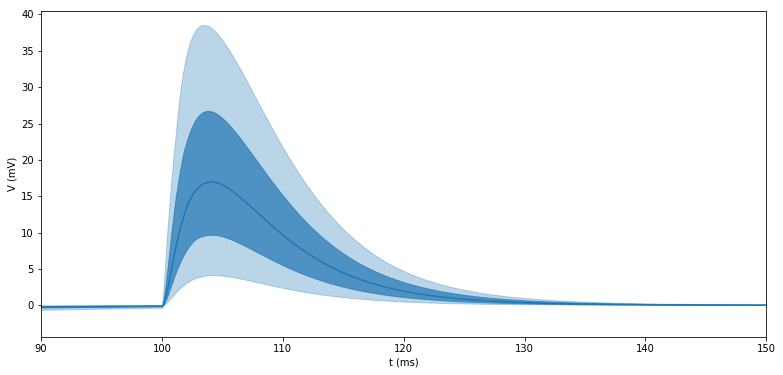

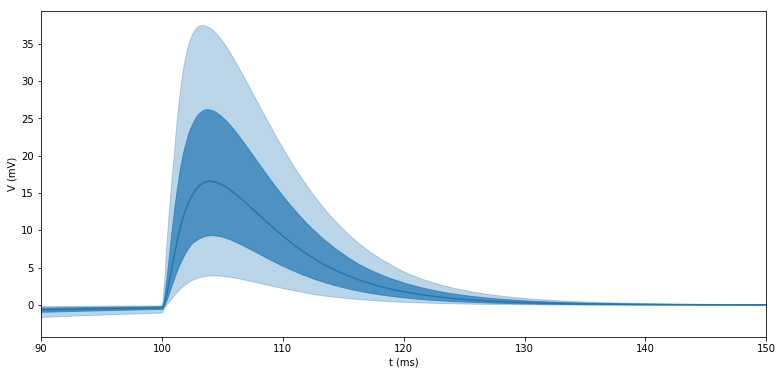

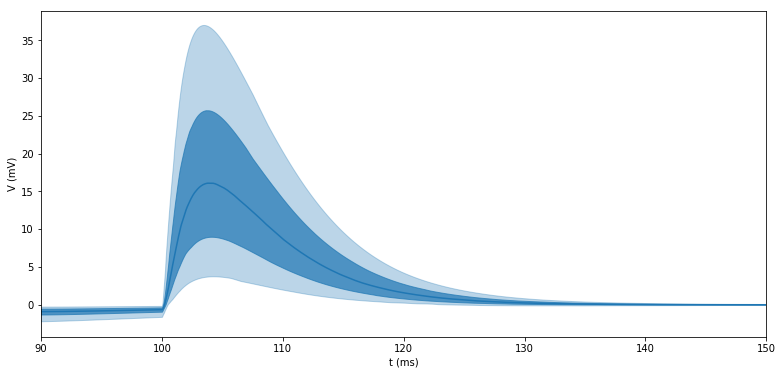

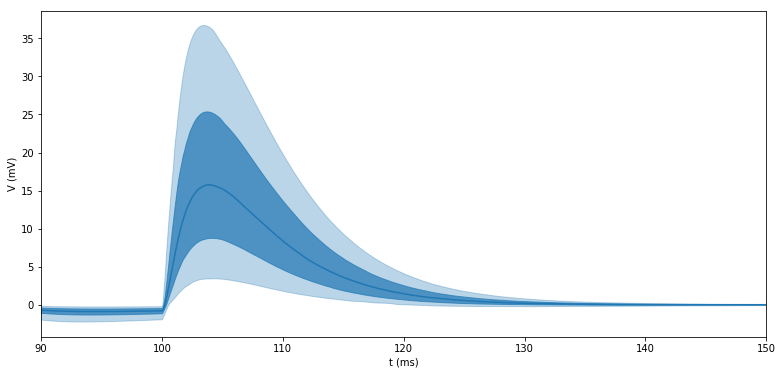

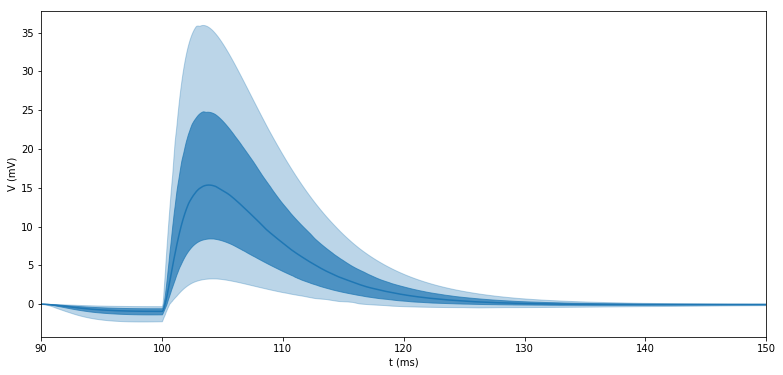

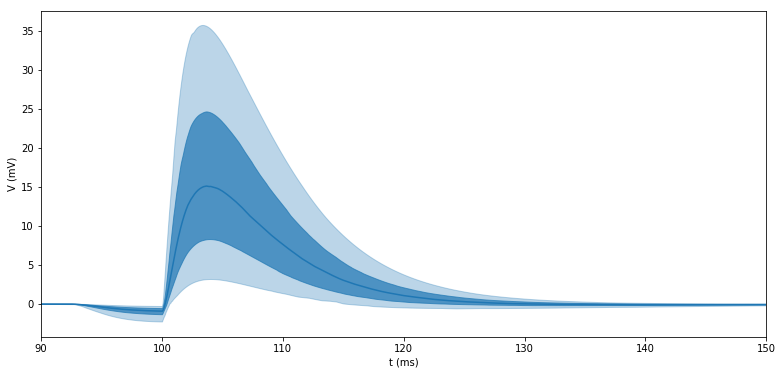

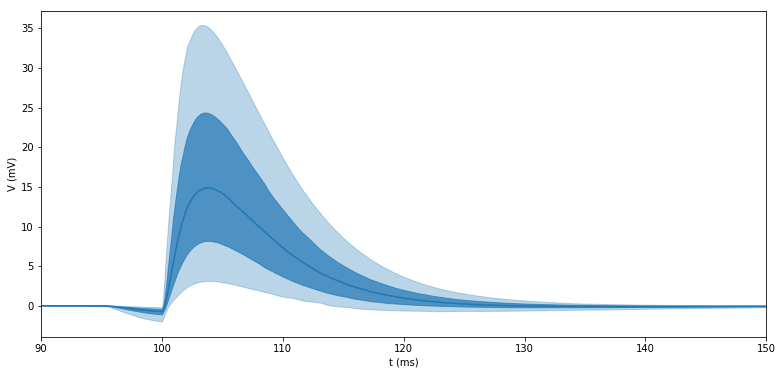

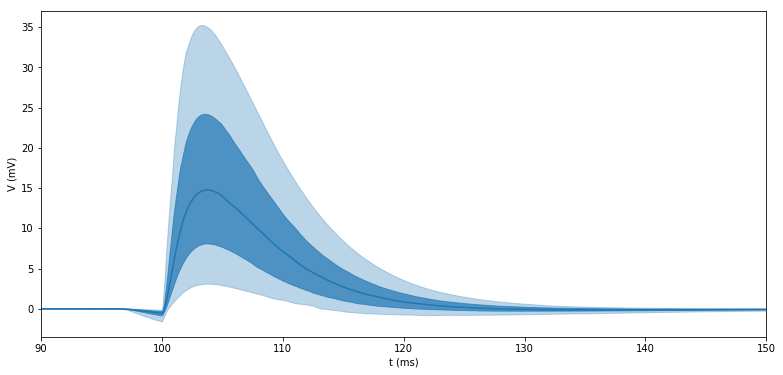

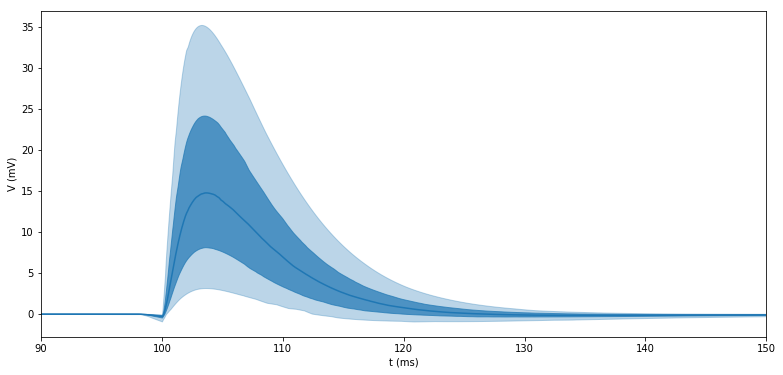

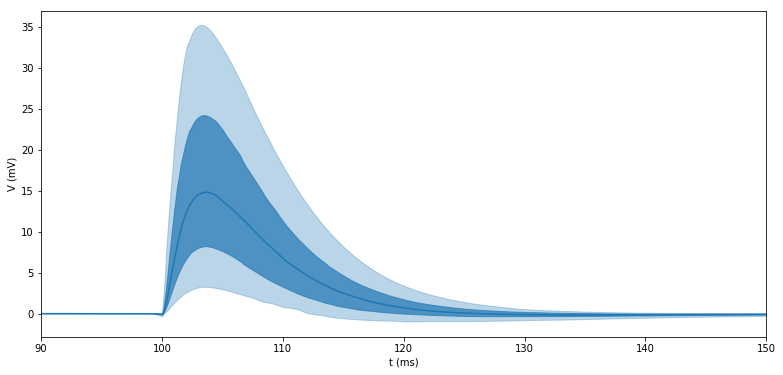

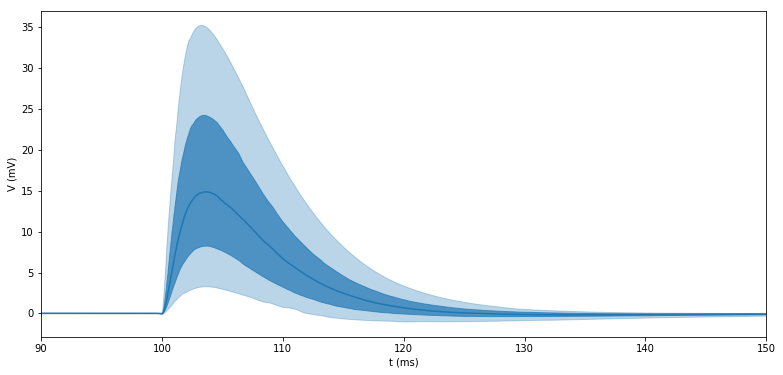

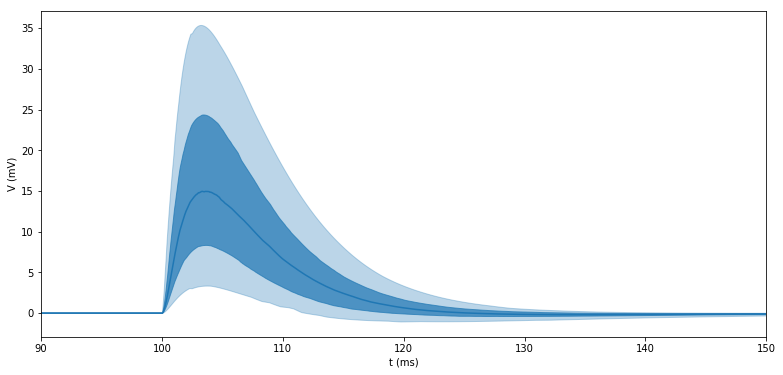

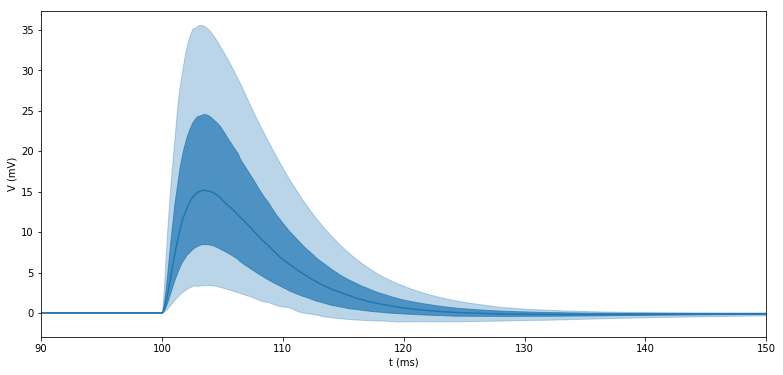

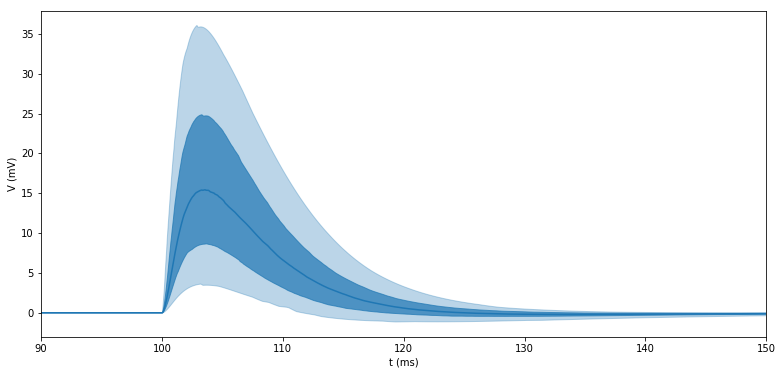

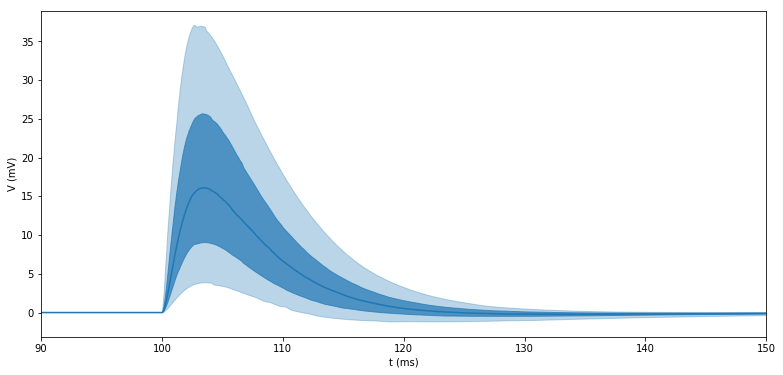

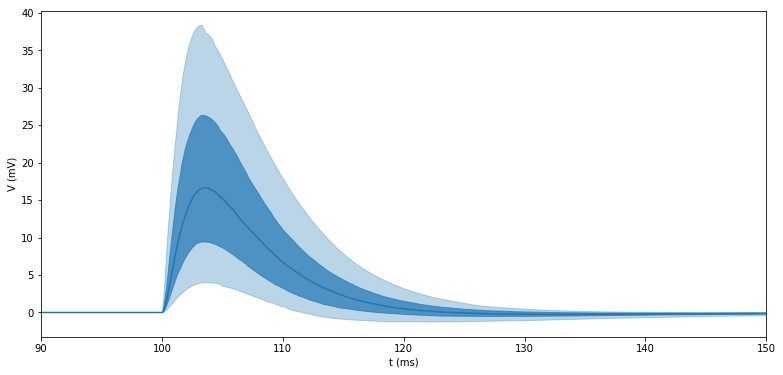

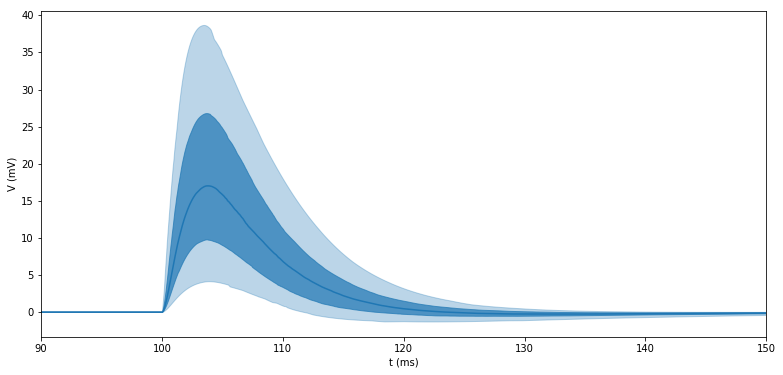

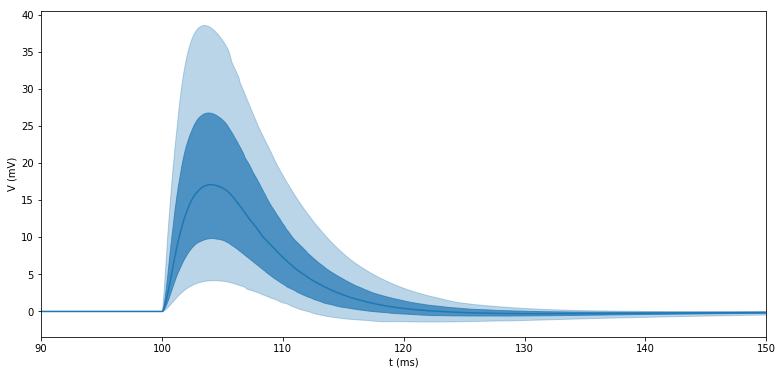

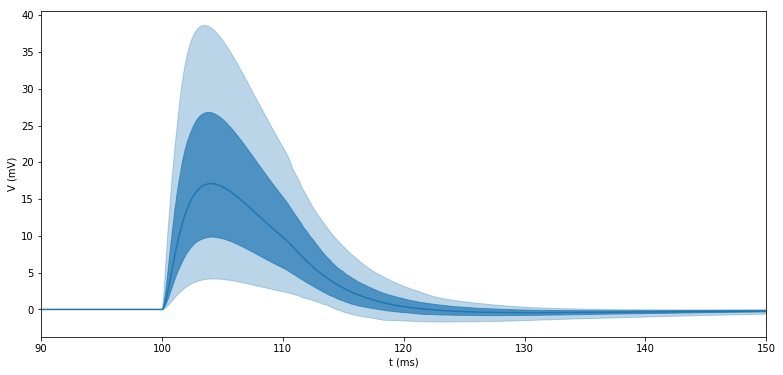

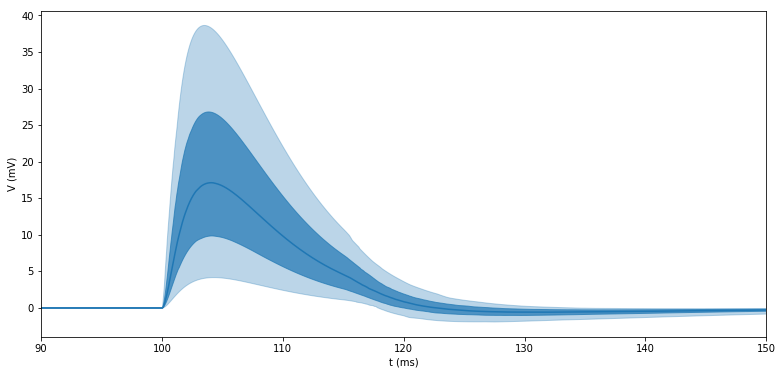

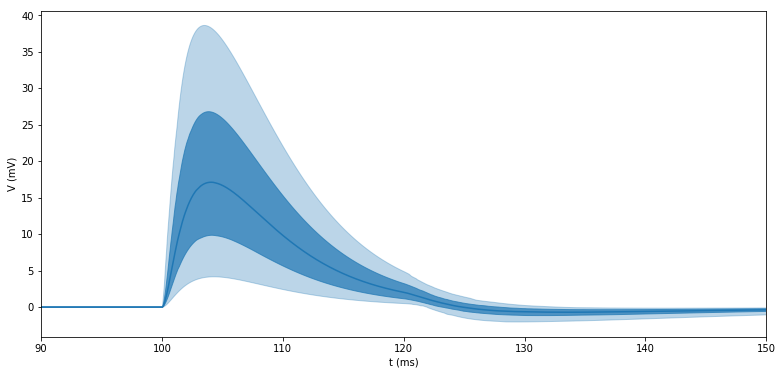

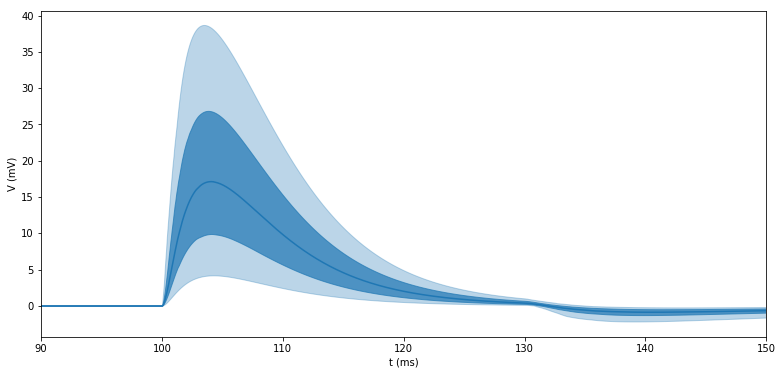

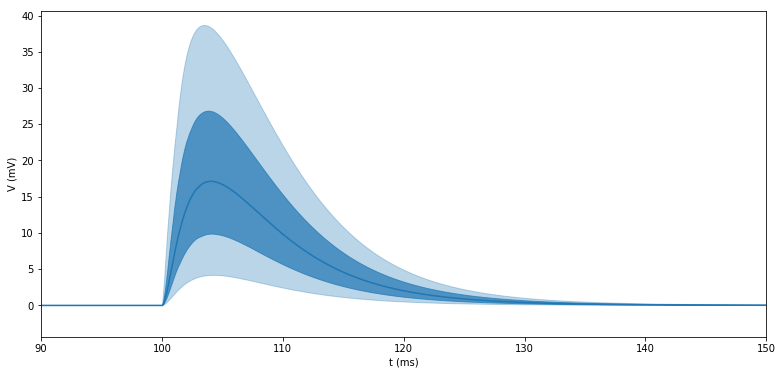

In [28]:
dend.Ra = 250
neck.Ra = 250
model.E_PAS = -65
model.soma.e_pas = model.E_PAS
for dendp in model.dend:
    dendp.e_pas = model.E_PAS
for sp in model.spne:
    sp.e_pas = model.E_PAS


tdels = [-49,-30,-20,-15,-10,-7.5,-5,-3.5,-2,-1,-0.5,0,0.5,1.0,2.0,2.75,3.5,5.0,10.0,15.0,20.,30.,50]


ton = 50
tG = ton-10
t_stop = 200
toffset = 50
t_stop = 250
mes = zeros((len(tdels),6))
me2 = zeros((len(tdels),10))

vm0,mes0,C0 = delinh(1000,dis)

for i,tG in enumerate(tdels):
    #lb.add_somaStim(model,p=0.5,onset=ton,dur=2, amp =0.0)
    
    vm,mest,Cs = delinh(tG,dis)
    
    mes[i,:] = mest.mean(axis=0)
    mest0 = mest[:,1:]/mes0[:,1:]
    me2[i,:] = concatenate((mest0.mean(axis=0),mest0.std(axis=0)))


    fig = figure(figsize=(13,6))

    ImaxnA = 1# (NC.weight[0]/area/model.CM*1e6)

    plot(trec,vm[:,0],label="Spine head")
    fill_between(trec,vm[:,1],vm[:,2],color='C0',alpha=0.7)
    fill_between(trec,vm[:,3],vm[:,4],color='C0',alpha=0.3)
    xlabel("t (ms)")
    ylabel("V (mV)")
    xlim(toffset+40,toffset+100)
    savefig("FigEI_t"+str(int(tG*10)).zfill(3)+".png",bbox_inches='tight',pad_inches = 0)
    vaF[tG] = vavg*1.0
    meF[tG] = mest*1.0

In [29]:
medata = 1.0*mes
medata0 = 1.0*mes0
medata2 = 1.0*me2

Text(0.5, 0, '$R_{neck}$')

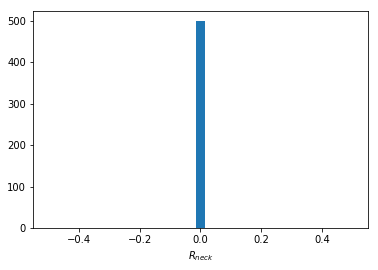

In [30]:
figure()
hist(mest[:,0]/1e6,31)
xlabel("$R_{neck}$")

In [31]:
me2.shape

(23, 10)

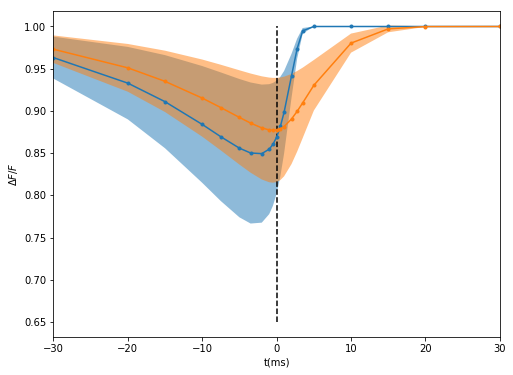

In [32]:
figure(figsize=(8,6))
#me2 = 1.0*medata2
sel = mes[:,0].argsort()
plot(tdels,me2[:,0],'.-',label=int(mes[0,-1]))
fill_between(tdels,me2[:,0]+me2[:,0+5],me2[:,0]-me2[:,0+5],alpha=0.5)

plot(tdels,me2[:,3],'.-',label=int(mes[0,-1]))
fill_between(tdels,me2[:,3]+me2[:,3+5],me2[:,3]-me2[:,3+5],alpha=0.5)

xlabel("t(ms)")
ylabel("$\Delta F/ F$")
xlim(-30,30)
#legend(title="$n_{GABAR}$")
vlines(0.0,0.65,1.0,linestyle="--")
savefig("CEItiming.png",bbox_inches='tight',pad_inches = 0)

In [98]:
me2.argmin(axis=0)
print(me2[8,:])
print(me2[8,0+5])
print(me2[11,:])
print(me2[8,3+5])

[0.76835121 0.74475411 0.7280396  0.81449081 0.76093482 0.11891401
 0.12735212 0.1345423  0.08063716 0.12201419]
0.11891401199794072
[0.78602483 0.7506548  0.72784464 0.81003896 0.7723758  0.10447642
 0.11835614 0.12901603 0.08169444 0.11145563]
0.08063716378727184


In [ ]:
min(me2[:,3])

In [99]:
vm0,mes0,C0 = delinh(1000,dis)


In [102]:
vmt = 1.0*vm0
sel = vmt[:,0].argsort()


(2501, 6)